In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from beer_knowledge import number_of_beer_per_style, add_global_knowledge, add_local_knowledge, add_experts, get_expert_per_day, get_global_expert_per_day

sns.set_theme()

In [ ]:
df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

In [6]:
df_rb_beers     = pd.read_csv('../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../data/rate_beer/ratings.csv')

In [7]:
df_rb_ratings["beer_global_style"].unique()

array(['Pale Lager', 'Pale Ale', 'Porter', 'Brown Ale', 'Speciality Beer',
       'India Pale Ale', 'Hybrid Beer', 'Dark Lager', 'Stout',
       'Strong Ale', 'Wheat Beer', 'Bock', 'Wild/Sour Beer', 'Dark Ales'],
      dtype=object)

In [8]:
df_ba_ratings['day']     = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('D')
df_ba_ratings['week']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_ba_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_ba_ratings['quarter'] = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Q')
df_ba_ratings['year']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Y')

df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

# Pre-processing 

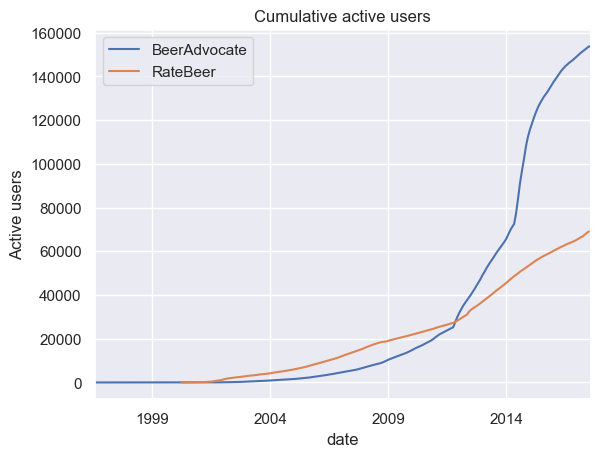

In [9]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_ba_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [10]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

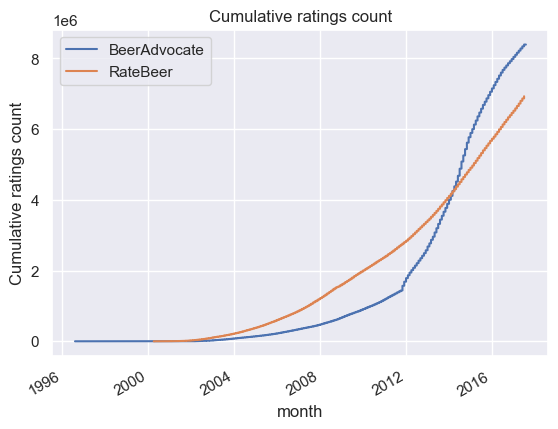

In [11]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

**Internet majority adoption is around 2004 (50% of population using it regularly) + lot of noise before 2004 so the analysis will focus on the time period after January 2004**

In [12]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [13]:
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 1. Inflations

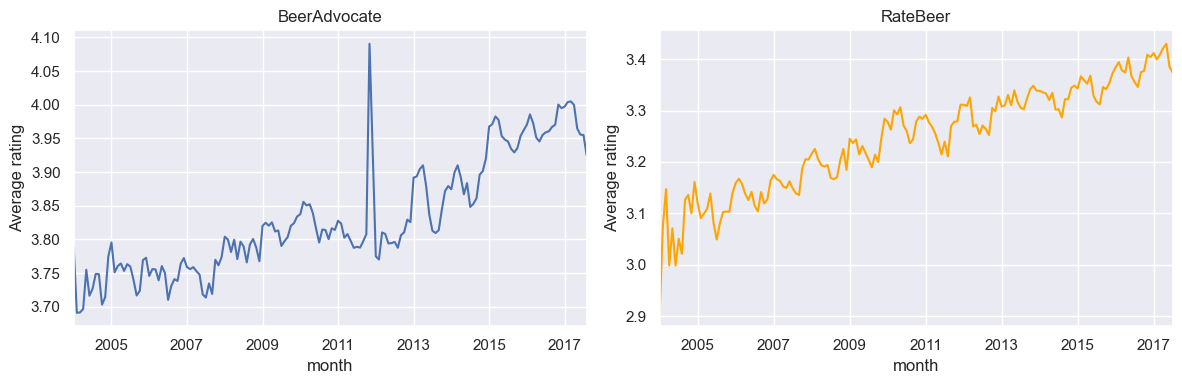

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

In [15]:
def create_time_serie(dataframe: pd.DataFrame, time_column: str, value_column: str, frequency: str = 'W') -> pd.DataFrame:
    full_range = pd.DataFrame(index=pd.date_range(start=dataframe[time_column].min(), end=dataframe[time_column].max(), freq=frequency).to_period('W').start_time)
    partial_time_serie = dataframe.groupby(time_column)[value_column].mean()
    time_serie = pd.merge(full_range, partial_time_serie, left_index=True, right_index=True, how='left').fillna(0)
    return time_serie

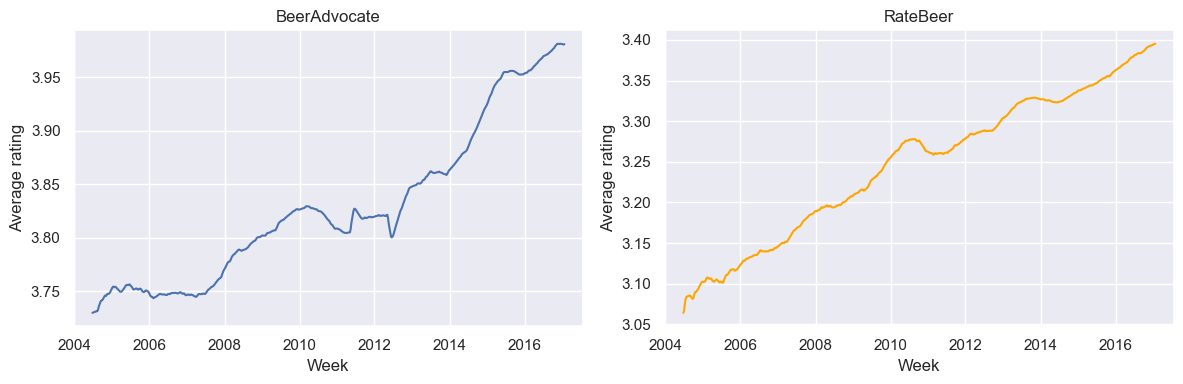

In [16]:
df_ba_decomposition = seasonal_decompose(create_time_serie(df_ba_ratings, 'week', 'rating'), model='additive', period=52)
df_rb_decomposition = seasonal_decompose(create_time_serie(df_rb_ratings, 'week', 'rating'), model='additive', period=52)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating general trend')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_decomposition.trend.plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_decomposition.trend.plot(ax=axs[1], color='orange')

plt.tight_layout()

In [17]:
def correct_inflation(dataframe: pd.DataFrame, trend: pd.Series) -> pd.DataFrame:
    trend = trend.dropna()
    reference_mean = trend.iloc[0]
    IPC = trend / reference_mean
    
    dataframe = dataframe.loc[dataframe['week'] >= trend.index[0]]

    beta_0 = IPC.iloc[0]
    beta_1 = (IPC.iloc[-1] - IPC.iloc[0]) / len(IPC)

    for week in pd.date_range(start=IPC.index.max(), end=dataframe['week'].max(), freq='W').to_period('W').start_time:
        diff = (week + pd.Timedelta(weeks=1) - IPC.index.min()) / pd.Timedelta(weeks=1)
        IPC.loc[week + pd.Timedelta(weeks=1)] = beta_0 + beta_1 * diff
    
    dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
    return dataframe

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values


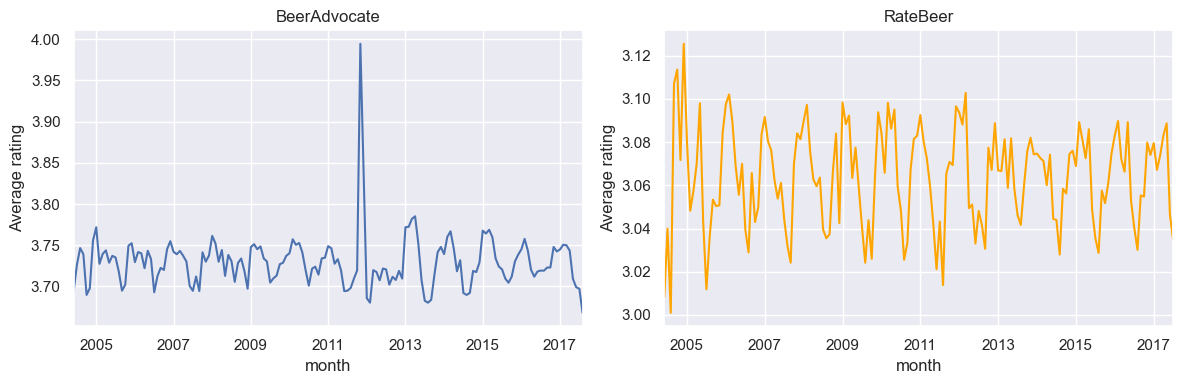

In [18]:
df_ba_ratings = correct_inflation(df_ba_ratings, df_ba_decomposition.trend)
df_rb_ratings = correct_inflation(df_rb_ratings, df_rb_decomposition.trend)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating average over time corrected for inflation')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

# 2. Rating scales

In [19]:
def compute_scale_distribution(dataframe: pd.DataFrame) -> pd.DataFrame:
    new_dataframe = dataframe.groupby('user_id')['rating_corrected'].quantile([0.01, 0.025, 0.05, 0.1, 0.9, 0.95, 0.975, 0.99]).unstack()
    new_dataframe = new_dataframe.merge(dataframe.groupby('user_id')['rating_corrected'].count(), left_index=True, right_index=True)
    new_dataframe = new_dataframe.rename(columns={'rating_corrected': 'count'}).dropna()
    new_dataframe['difference'] = new_dataframe[0.975] - new_dataframe[0.025]
    new_dataframe.columns = [str(c) for c in new_dataframe.columns]
    return new_dataframe

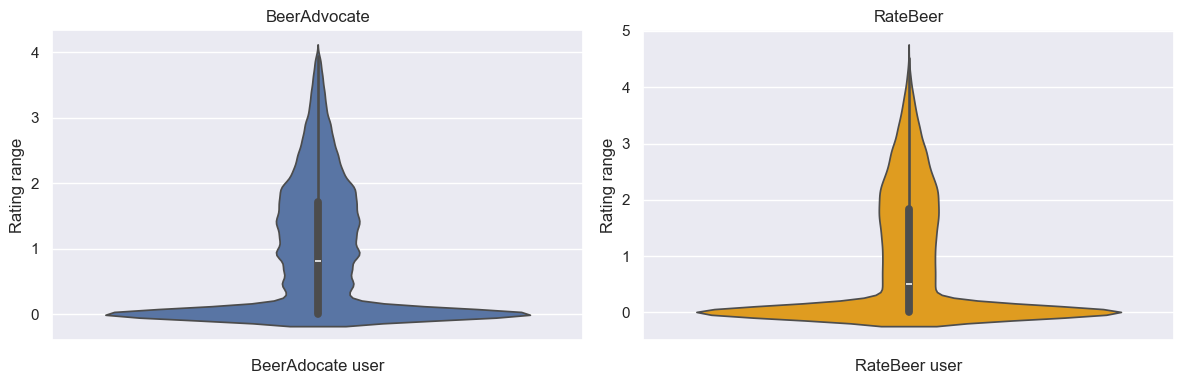

In [20]:
df_ba_scales = compute_scale_distribution(df_ba_ratings)
df_rb_scales = compute_scale_distribution(df_rb_ratings)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Distribution of rating range')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(df_ba_scales['difference'], ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales['difference'], ax=axs[1], color='orange')

plt.tight_layout()

In [21]:
for threshold in [10, 50, 100, 500, 1000]:
    df_ba_scales[f'at_least_{threshold}'] = (df_ba_scales['count'] > threshold).astype(int) * threshold
    df_rb_scales[f'at_least_{threshold}'] = (df_rb_scales['count'] > threshold).astype(int) * threshold

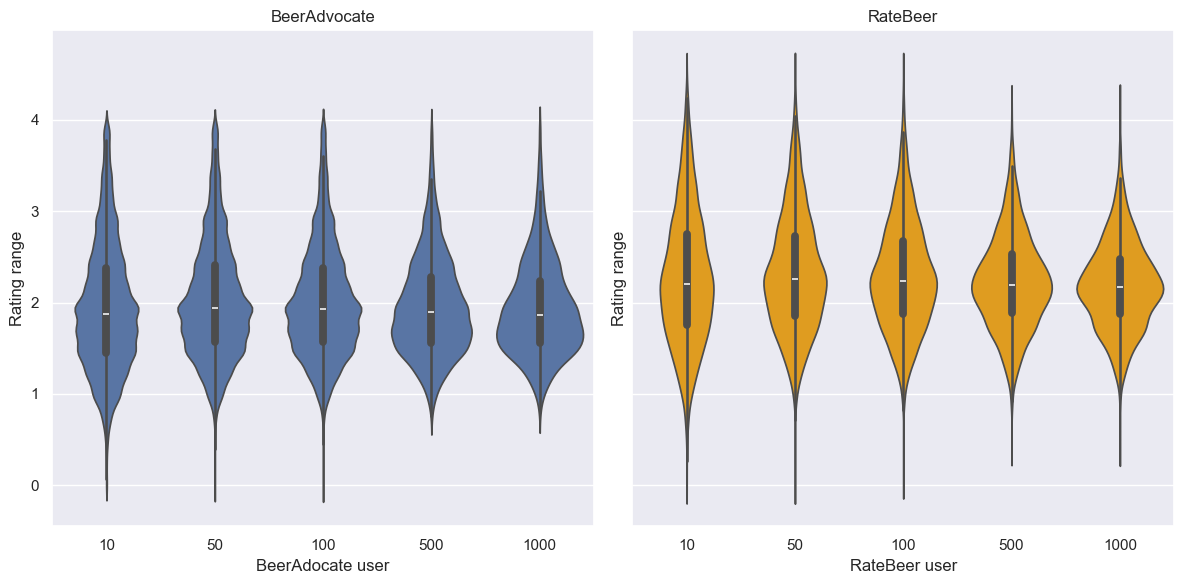

In [22]:
df_ba_scales = pd.wide_to_long(df_ba_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])
df_rb_scales = pd.wide_to_long(df_rb_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.title('Distribution of rating ranges')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(data=df_ba_scales[df_ba_scales['count'] > df_ba_scales['threshold']], x='threshold', y='difference', ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales[df_rb_scales['count'] > df_rb_scales['threshold']], x='threshold', y='difference', ax=axs[1], color='orange')

plt.tight_layout()

# Past ratings and count

In [28]:
def get_past_ratings_count_and_average(
    df_ratings: pd.DataFrame,
    sorting_columns: list[str],
    grouping_columns: list[str],
    name: str,
    shift: bool,
) -> pd.DataFrame:
    df_ratings = df_ratings.sort_values(sorting_columns, kind="stable")

    if shift:
        df_ratings[f"{name}_past_ratings_count"] = df_ratings.groupby(
            grouping_columns
        ).cumcount()
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .shift()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )
    else:
        df_ratings[f"{name}_past_ratings_count"] = (
            df_ratings.groupby(grouping_columns).cumcount() + 1
        )
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )

    df_ratings.loc[
        df_ratings[f"{name}_past_ratings_count"] == 0, f"{name}_past_ratings_average"
    ] = pd.NA

    df_ratings = df_ratings.sort_index()
    return df_ratings

def get_past_ratings_counts_all_style(
    df_ratings: pd.DataFrame, dummy_column: str, multiplying_columns_prefix: str
) -> pd.DataFrame:
    # Create one-hot encoded binary matrix for the beer styles
    beer_styles_one_hot_encoding = pd.get_dummies(
        df_ratings[dummy_column], dtype=int, prefix="user_past_ratings"
    ).replace(0, pd.NA)

    # Multiply the binary matrix with the past ratings count and average corresponding to the current rating style
    df_user_beer_style_past_ratings = pd.merge(
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_count"], axis=0
        ),
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_average"], axis=0
        ),
        left_index=True,
        right_index=True,
        suffixes=("_count", "_average"),
    )

    modified_columns = [
        column
        for column in df_user_beer_style_past_ratings.columns
        if ("_count" in column or "_average" in column)
    ]

    # Merge to get the user id and date in order to forward fill the values within groups of user_id
    df_user_beer_style_past_ratings = df_user_beer_style_past_ratings.merge(
        df_ratings[["user_id", "date", "beer_id"]],
        left_index=True,
        right_index=True,
        how="left",
    )

    # Ensure duplicate are well sorted by the next sorting
    df_user_beer_style_past_ratings.sort_index(inplace=True)

    # Fill forward the values within groups of user_id
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .ffill()[modified_columns]
    )

    # Shift the value forward to have the counts and average without taking into
    # account the current rating (since counts and average are computed taking
    # into account current rating)
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .shift(1)[modified_columns]
    )

    # Fill remaining cells with 0 as they are cells of ratings occuring before
    # the first rating in a given beer style
    df_user_beer_style_past_ratings[modified_columns] = df_user_beer_style_past_ratings[
        modified_columns
    ].fillna(0.0)

    return df_user_beer_style_past_ratings



In [24]:
df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_ba_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_ba_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [25]:
df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_rb_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_rb_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [26]:
df_ba_user_beer_style_past_ratings.to_csv("../data/beer_advocate/user_beer_style_past_ratings_inflation.csv",index=False)
df_rb_user_beer_style_past_ratings.to_csv("../data/rate_beer/user_beer_style_past_ratings_inflation.csv",index=False)

In [27]:
df_rb_ratings.to_csv("../data/rate_beer/ratings_inflation.csv",index=False)
df_ba_ratings.to_csv("../data/beer_advocate/ratings_inflation.csv",index=False)

# Knowledge

# Beer Advocate

In [178]:
df_ba_user_beer_style_past_ratings = pd.read_csv("../data/beer_advocate/user_beer_style_past_ratings.csv")
df_ba_ratings = pd.read_csv("../data/beer_advocate/ratings.csv")

In [180]:
df_ba_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_ba_ratings["user_beer_style_past_ratings_count"] - 1
df_ba_ratings.loc[df_ba_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_ba_ratings['date_day'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.round('D')
df_ba_ratings.drop(df_ba_ratings[df_ba_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

#To preprocess once and for all
df_ba_user_beer_style_past_ratings['date_day'] = pd.to_datetime(df_ba_user_beer_style_past_ratings['date'], unit="s").dt.round('D')
df_ba_user_beer_style_past_ratings.drop(["user_past_ratings_Low Alcohol Beer_count","user_past_ratings_Low Alcohol Beer_average"],axis=1,inplace=True)

In [181]:
df_current_beer_per_style = number_of_beer_per_style(df_ba_ratings)

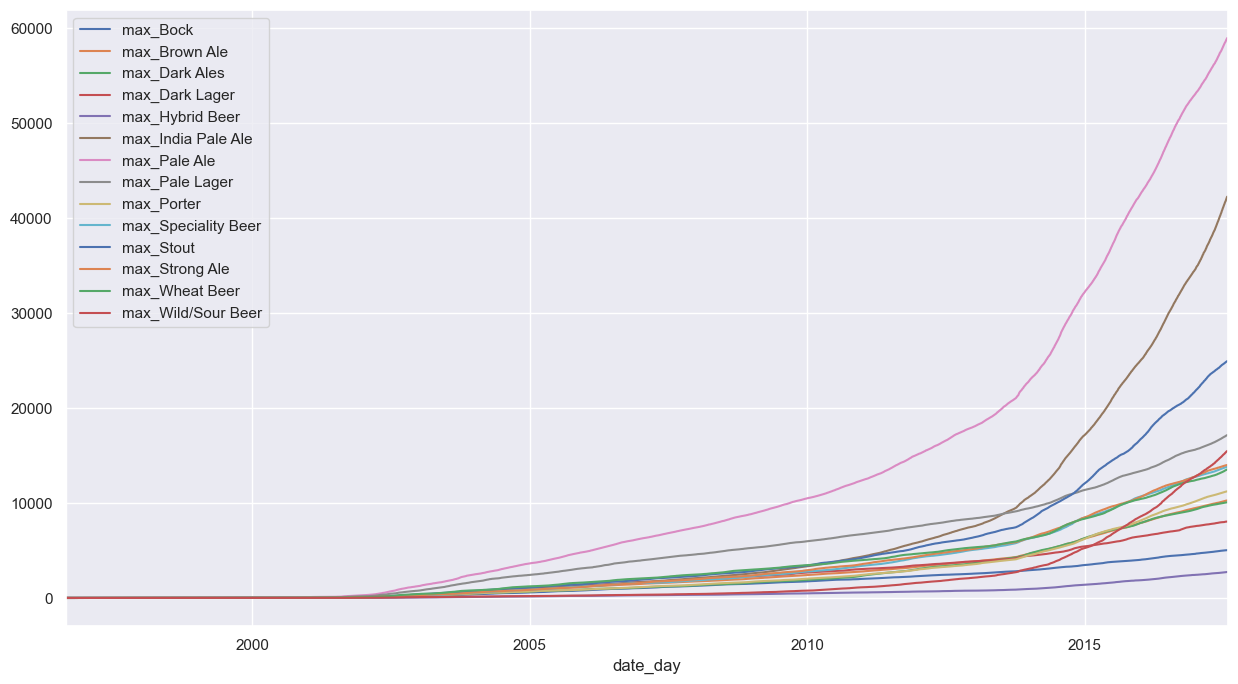

In [182]:
df_current_beer_per_style.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

<u style="background-color:red;">Interpretation:</u> : Growing number of available beer with a bigger slope since 2003 and then agan in 2013

In [183]:
average_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "average" in col]
count_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style.columns if "max" in col]

In [184]:
df_ba_user_beer_style_past_ratings = add_global_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, count_columns)
df_ba_user_beer_style_past_ratings, df_local_knowledge = add_local_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, max_columns, count_columns)

df_knowledge = df_ba_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2

df_knowledge = df_knowledge.drop(df_knowledge[df_knowledge["local_knowledge"] == 0].index, axis=0)

df_prime_knowledge = df_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/beer_knowledge.py:105: RuntimeWarning:

invalid value encountered in divide

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1020940568.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



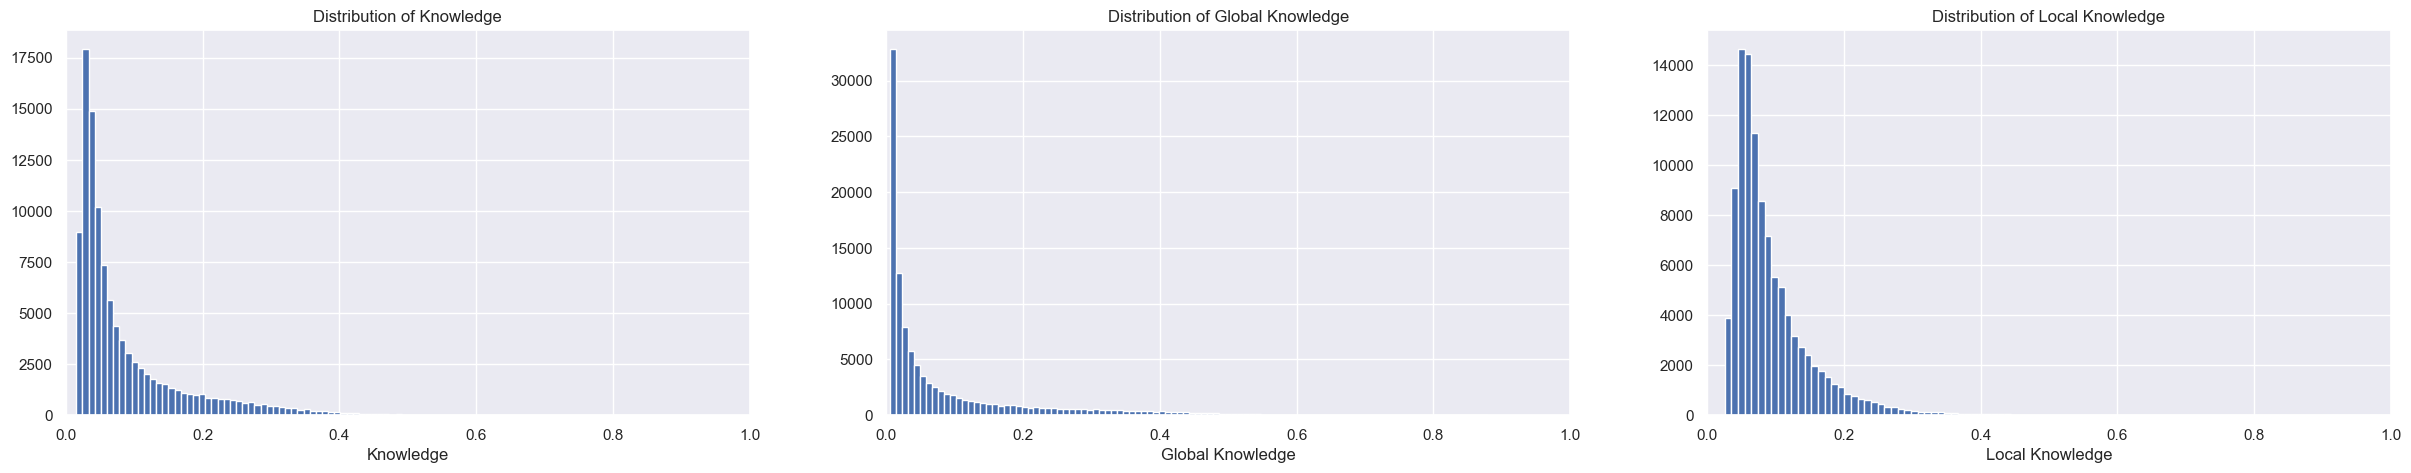

In [185]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_prime_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_prime_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_prime_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

<u style="background-color:red;">Interpretation:</u> : Right-skewed distribution for the *knowledge* as the user with high knowledge are quite rare. It's clear for the *global knowledge* that it is almost impossible to reach a really high level mostly because of the size of the beer dataset. Finally the *local knowledge* is more evenly distributed between 0 and 0.6 highlighting the clear possibility to find a beer style in which one's can thrive.

In [186]:
df_highest_global_knowledge = df_knowledge.loc[df_knowledge[["user_id","global_knowledge"]].groupby("user_id").idxmax().reset_index()["global_knowledge"]]

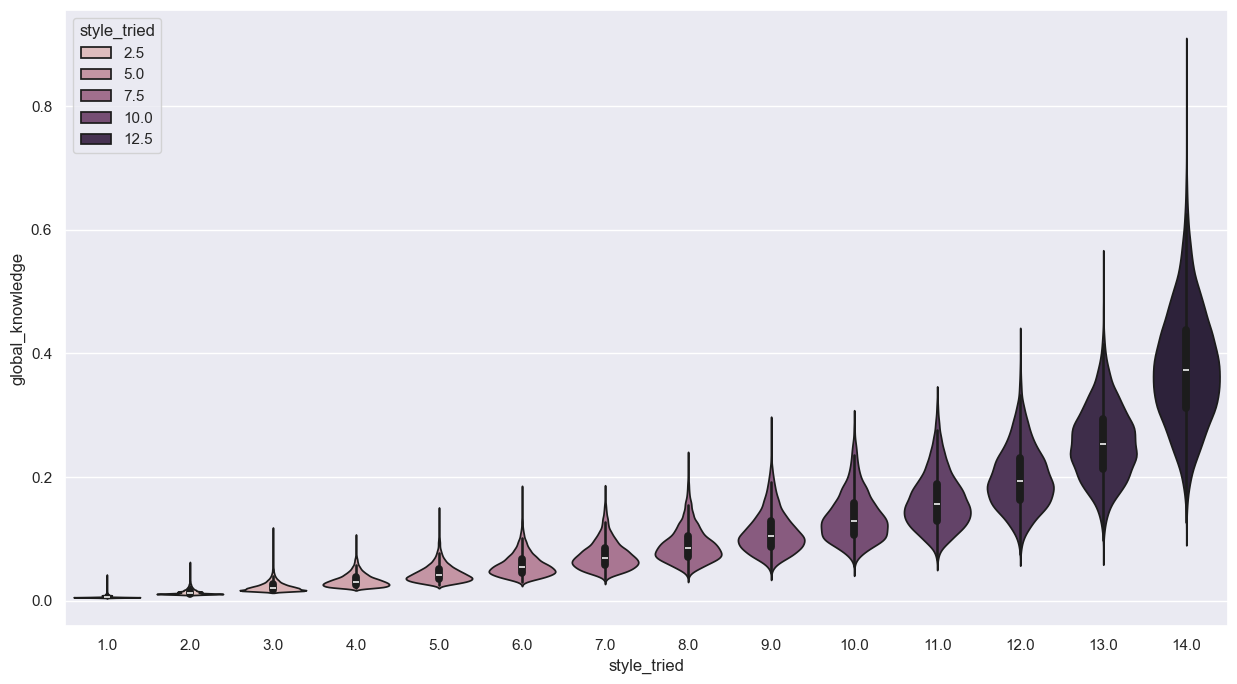

In [187]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_highest_global_knowledge["style_tried"],y=df_highest_global_knowledge["global_knowledge"],hue=df_highest_global_knowledge["style_tried"])
plt.show()

In [188]:
df_highest_global_knowledge_per_style_tried = df_knowledge.loc[df_knowledge[["user_id","global_knowledge","style_tried"]].groupby(["user_id","style_tried"]).idxmax().reset_index()["global_knowledge"]]

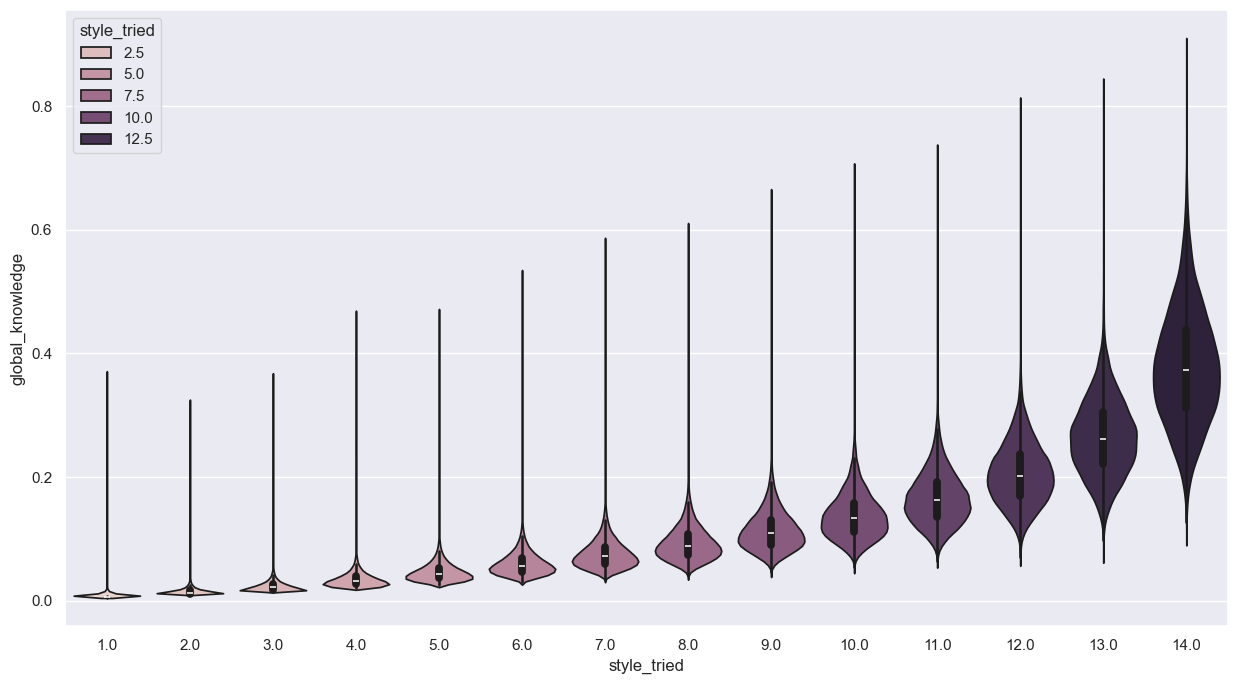

In [189]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_highest_global_knowledge_per_style_tried["style_tried"],y=df_highest_global_knowledge_per_style_tried["global_knowledge"],hue=df_highest_global_knowledge_per_style_tried["style_tried"])
plt.show()

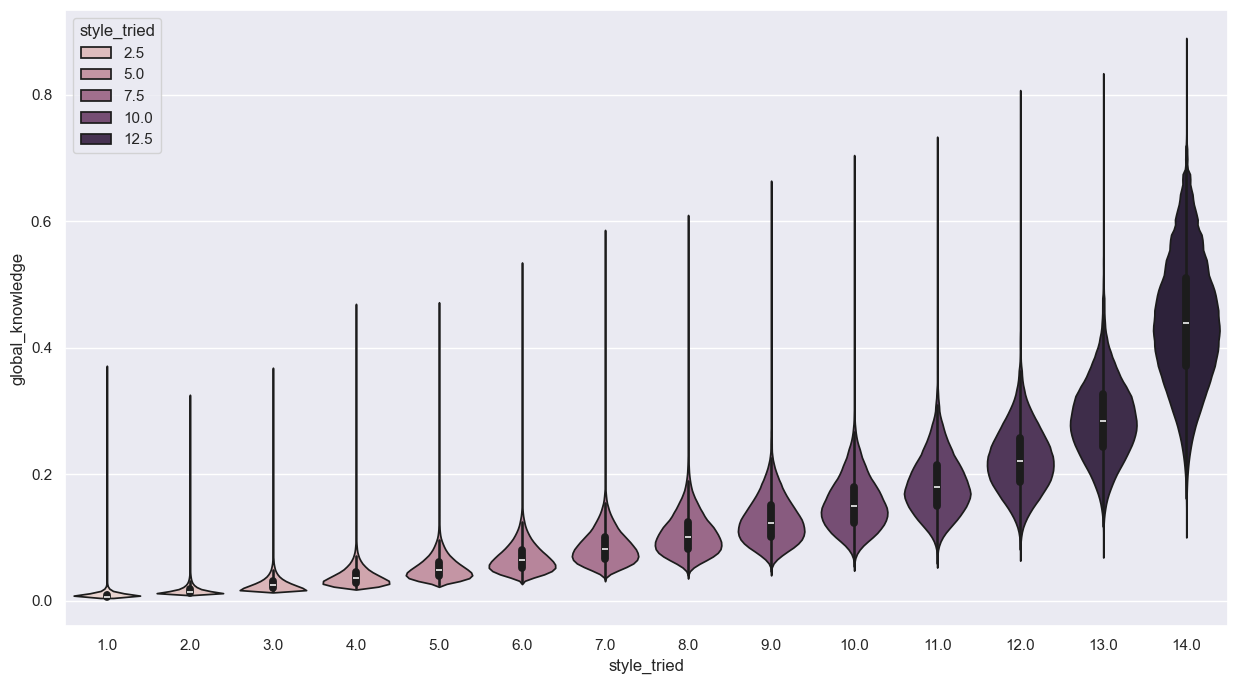

In [190]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_knowledge["style_tried"],y=df_knowledge["global_knowledge"],hue=df_knowledge["style_tried"])
plt.show()

<u style="background-color:red;">Interpretation:</u> : Although the number of beer style tried has quite of an impact on the *global knowledge* of a user, it is not impossible to reach a reasonable amount without trying all the styles. 

### CHOOSE BEST VIZ AMONGST THREE ABOVE

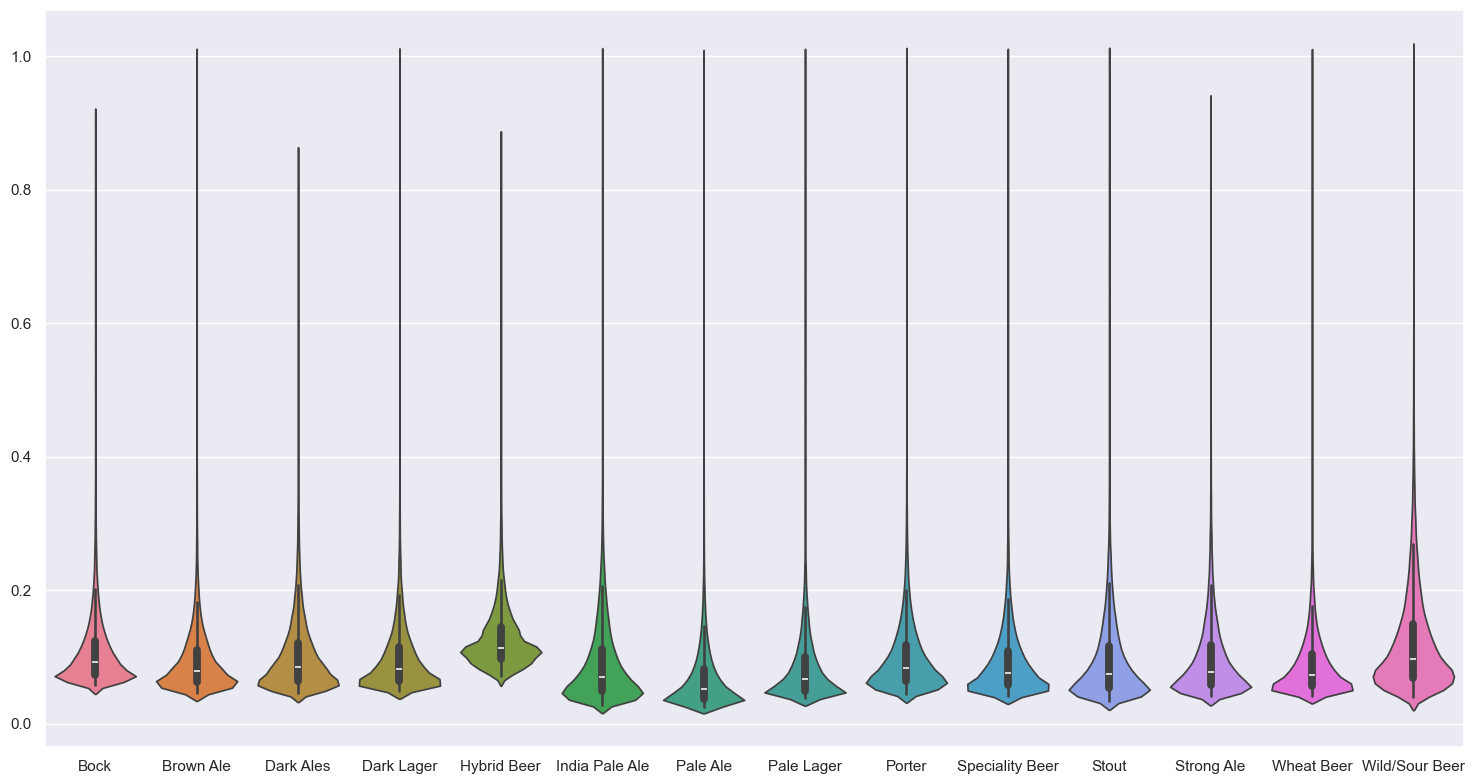

In [191]:
plt.figure(figsize=(15,8))
sns.violinplot(df_local_knowledge.iloc[:,:-1].groupby("user_id").max().reset_index().replace(0,np.nan))
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> : This plot shows the distribution of *local knowledge* for each of beer style. It highlights the difficulty to enter the beer style as the lowest *local knowledge* reached varies such as the gap between Hybrid Beer and IPA. It's mainly due to the number of beers available for this style since a beer from a small beer style would provide more local knowledge than one in a big beer style. Moreover it also highlights the difficulty to reach high level of *local knowledge* in the different beer styles (find cause)

# Experts

In [192]:
df_ba_user_beer_style_past_ratings, df_local_knowledge_quantile_expert = add_experts(df_local_knowledge, df_ba_user_beer_style_past_ratings,0.99)

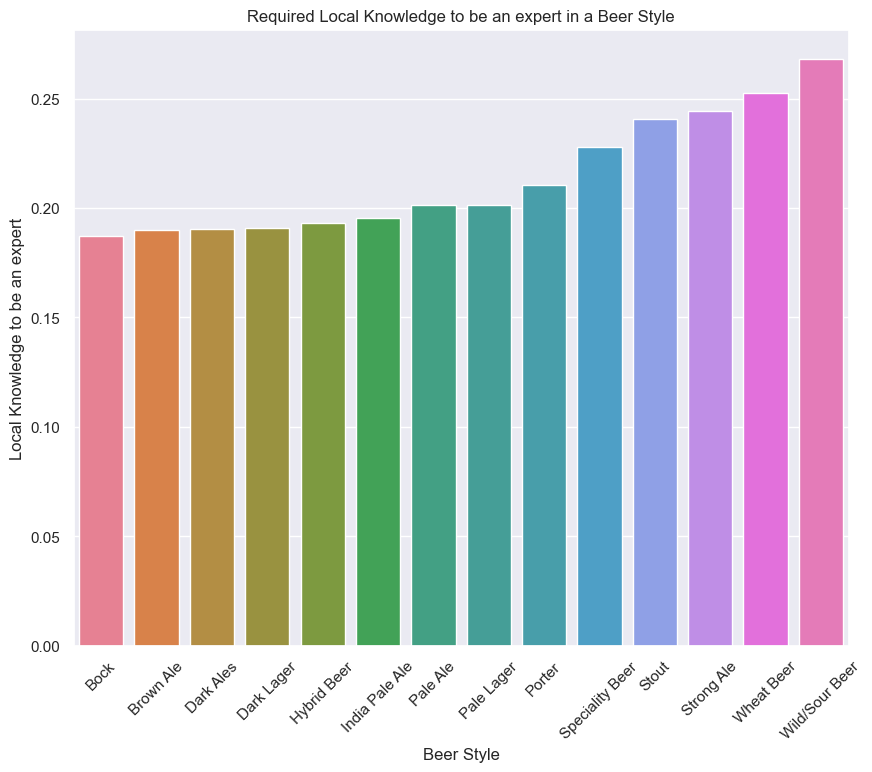

In [193]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_local_knowledge_quantile_expert.index, y=df_local_knowledge_quantile_expert.sort_values(), hue=df_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.ylabel("Local Knowledge to be an expert")
plt.xlabel("Beer Style")
plt.title("Required Local Knowledge to be an expert in a Beer Style")
plt.show()

<u style="background-color:red;">Interpretation:</u> : Not all beer styles are equal in the required level of local knowledge to reach to be an *expert*. In fact the experts are only the user located at the tails for each style in the previous plot. The bigger the beer style, the lower the local knowledge to reach to be an expert : if there are more beers to rate then the knowledge gain per beer is smaller and the expert level of knowledge is smaller too. Nonetheless the more popular the beer style, the higher the local knowledge to reach to be an expert : if the beer style is more popular then more users tried it and therefore the top-1% is shifted upwards requiring more local knowledge. Example of IPA and Hybrid Beer having a similar local knowledge threshold because IPA is a big and popular beer style (88980 unique users for 41688 beers) while Hybrid Beer is a small and niche beer style (17408 unique users for 2642 beers).

In [194]:
df_ba_ratings[["user_id","beer_global_style"]].drop_duplicates().groupby("beer_global_style").count()

user_id
beer_global_style         
Bock                 29660
Brown Ale            36825
Dark Ales            44881
Dark Lager           36274
Hybrid Beer          17845
India Pale Ale       89688
Pale Ale             75466
Pale Lager           47606
Porter               40757
Speciality Beer      48725
Stout                65887
Strong Ale           54263
Wheat Beer           46377
Wild/Sour Beer       32106

In [195]:
df_ba_ratings[["beer_id","beer_global_style"]].drop_duplicates().groupby("beer_global_style").count()

beer_id
beer_global_style         
Bock                  5037
Brown Ale            10277
Dark Ales            10077
Dark Lager            8049
Hybrid Beer           2739
India Pale Ale       42263
Pale Ale             58961
Pale Lager           17154
Porter               11235
Speciality Beer      13803
Stout                24944
Strong Ale           14004
Wheat Beer           13531
Wild/Sour Beer       15488

In [196]:
max_available_beer_per_day = df_ba_user_beer_style_past_ratings[max_columns+["date_day"]].groupby("date_day").max().reset_index()
max_available_beer_per_day.columns = ["date_day"] + df_local_knowledge_quantile_expert.index.to_list()
max_available_beer_per_day.iloc[:,1:] = max_available_beer_per_day.iloc[:,1:] * np.pow(df_local_knowledge_quantile_expert,3)
df_beer_required_to_be_expert_long = max_available_beer_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Beers to be expert')

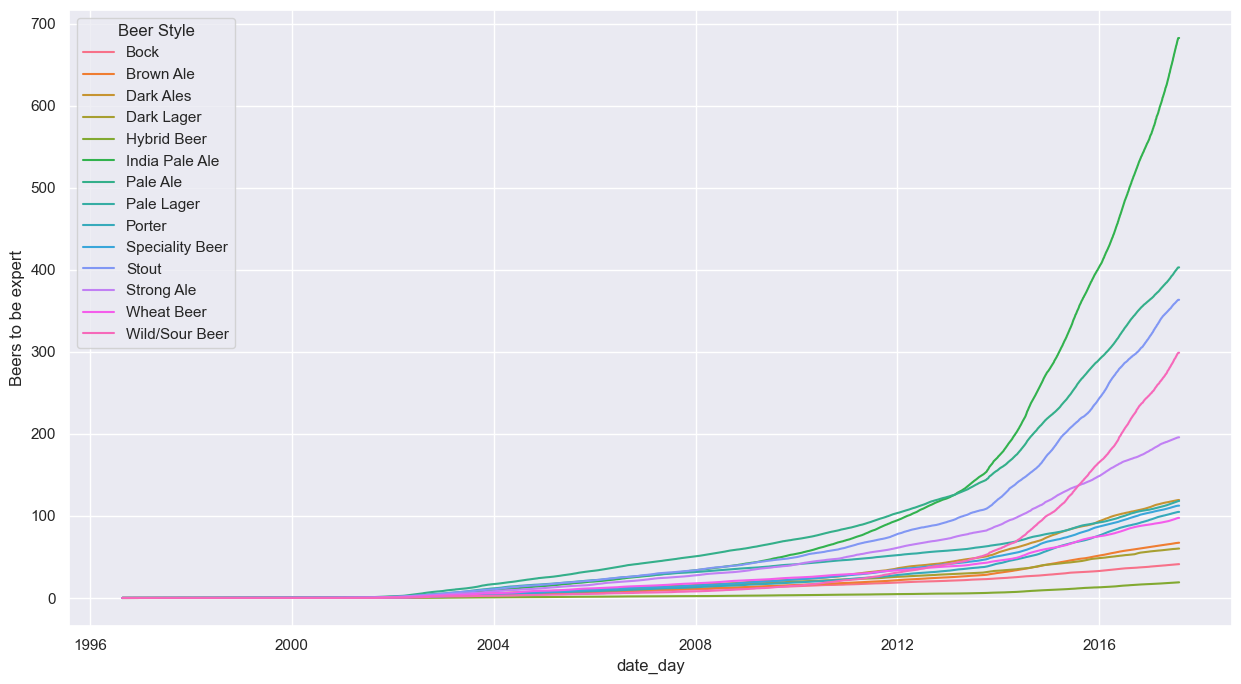

In [197]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_beer_required_to_be_expert_long["date_day"],y=df_beer_required_to_be_expert_long["Beers to be expert"], hue=df_beer_required_to_be_expert_long["Beer Style"])
plt.show()

<u style="background-color:red;">Interpretation:</u> : As the number of available beers per style grows, the required knowledge to be an expert follow a fairly similar trend.

In [198]:
expert_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "expert" in col]
n_unique_experts_per_style = df_ba_user_beer_style_past_ratings[expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_ba_user_beer_style_past_ratings.loc[:,"isExpert"] = df_ba_user_beer_style_past_ratings[expert_columns].sum(axis=1)
df_expert_users = df_ba_user_beer_style_past_ratings.loc[df_ba_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"]+expert_columns].groupby("user_id").max().reset_index().merge(df_ba_users[["user_id","user_country"]], how="left", on="user_id")

In [199]:
df_expert_users = df_expert_users.merge(df_ba_users[["user_id","user_country_code"]], how="left", on="user_id")

In [200]:
df_count_exp = df_expert_users["user_country_code"].value_counts().reset_index()
df_count_exp["log_count"] = np.log(df_count_exp["count"])

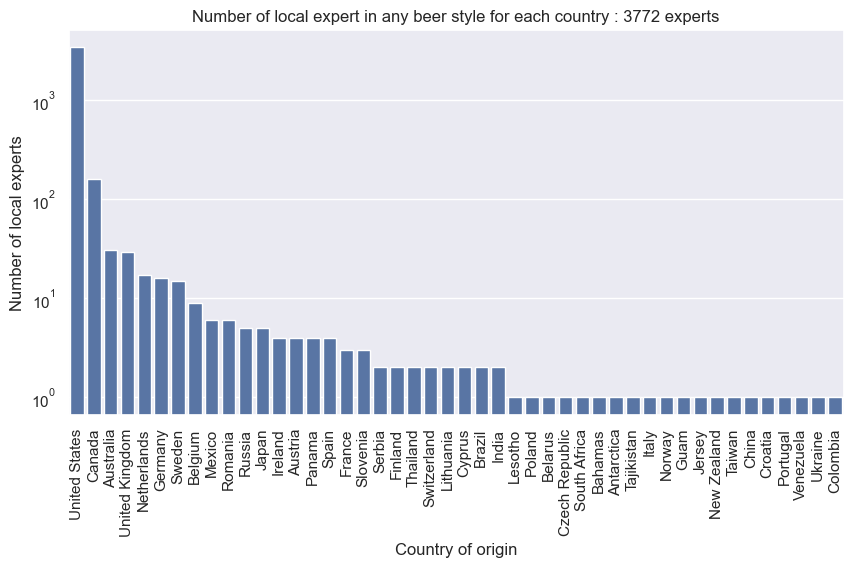

In [201]:
plt.figure(figsize=(10,5))
sns.barplot(df_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.title(f"Number of local expert in any beer style for each country : {df_expert_users["user_country"].value_counts().sum().item()} experts")
plt.yscale("log")
plt.show()

<u style="background-color:red;">Interpretation:</u> : With a massive domination, the United States are the clear leader of the world beer expertise. It is then followed by Canada before seeing a group of beer enthusiasts countries : United Kingdom, Australia, Sweden, Netherlands, Germany. We can also observe some smaller places where you can find an expert such as the incredible Svalbard and Jan Mayen Islands in the Artict Circle.

In [202]:
import plotly.io as pio
pio.renderers.default = 'browser'  # Use browser for rendering

In [203]:
fig = px.choropleth(
    df_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)


# Update layout for better visualization
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type='mercator')
)

# Display the map
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of t

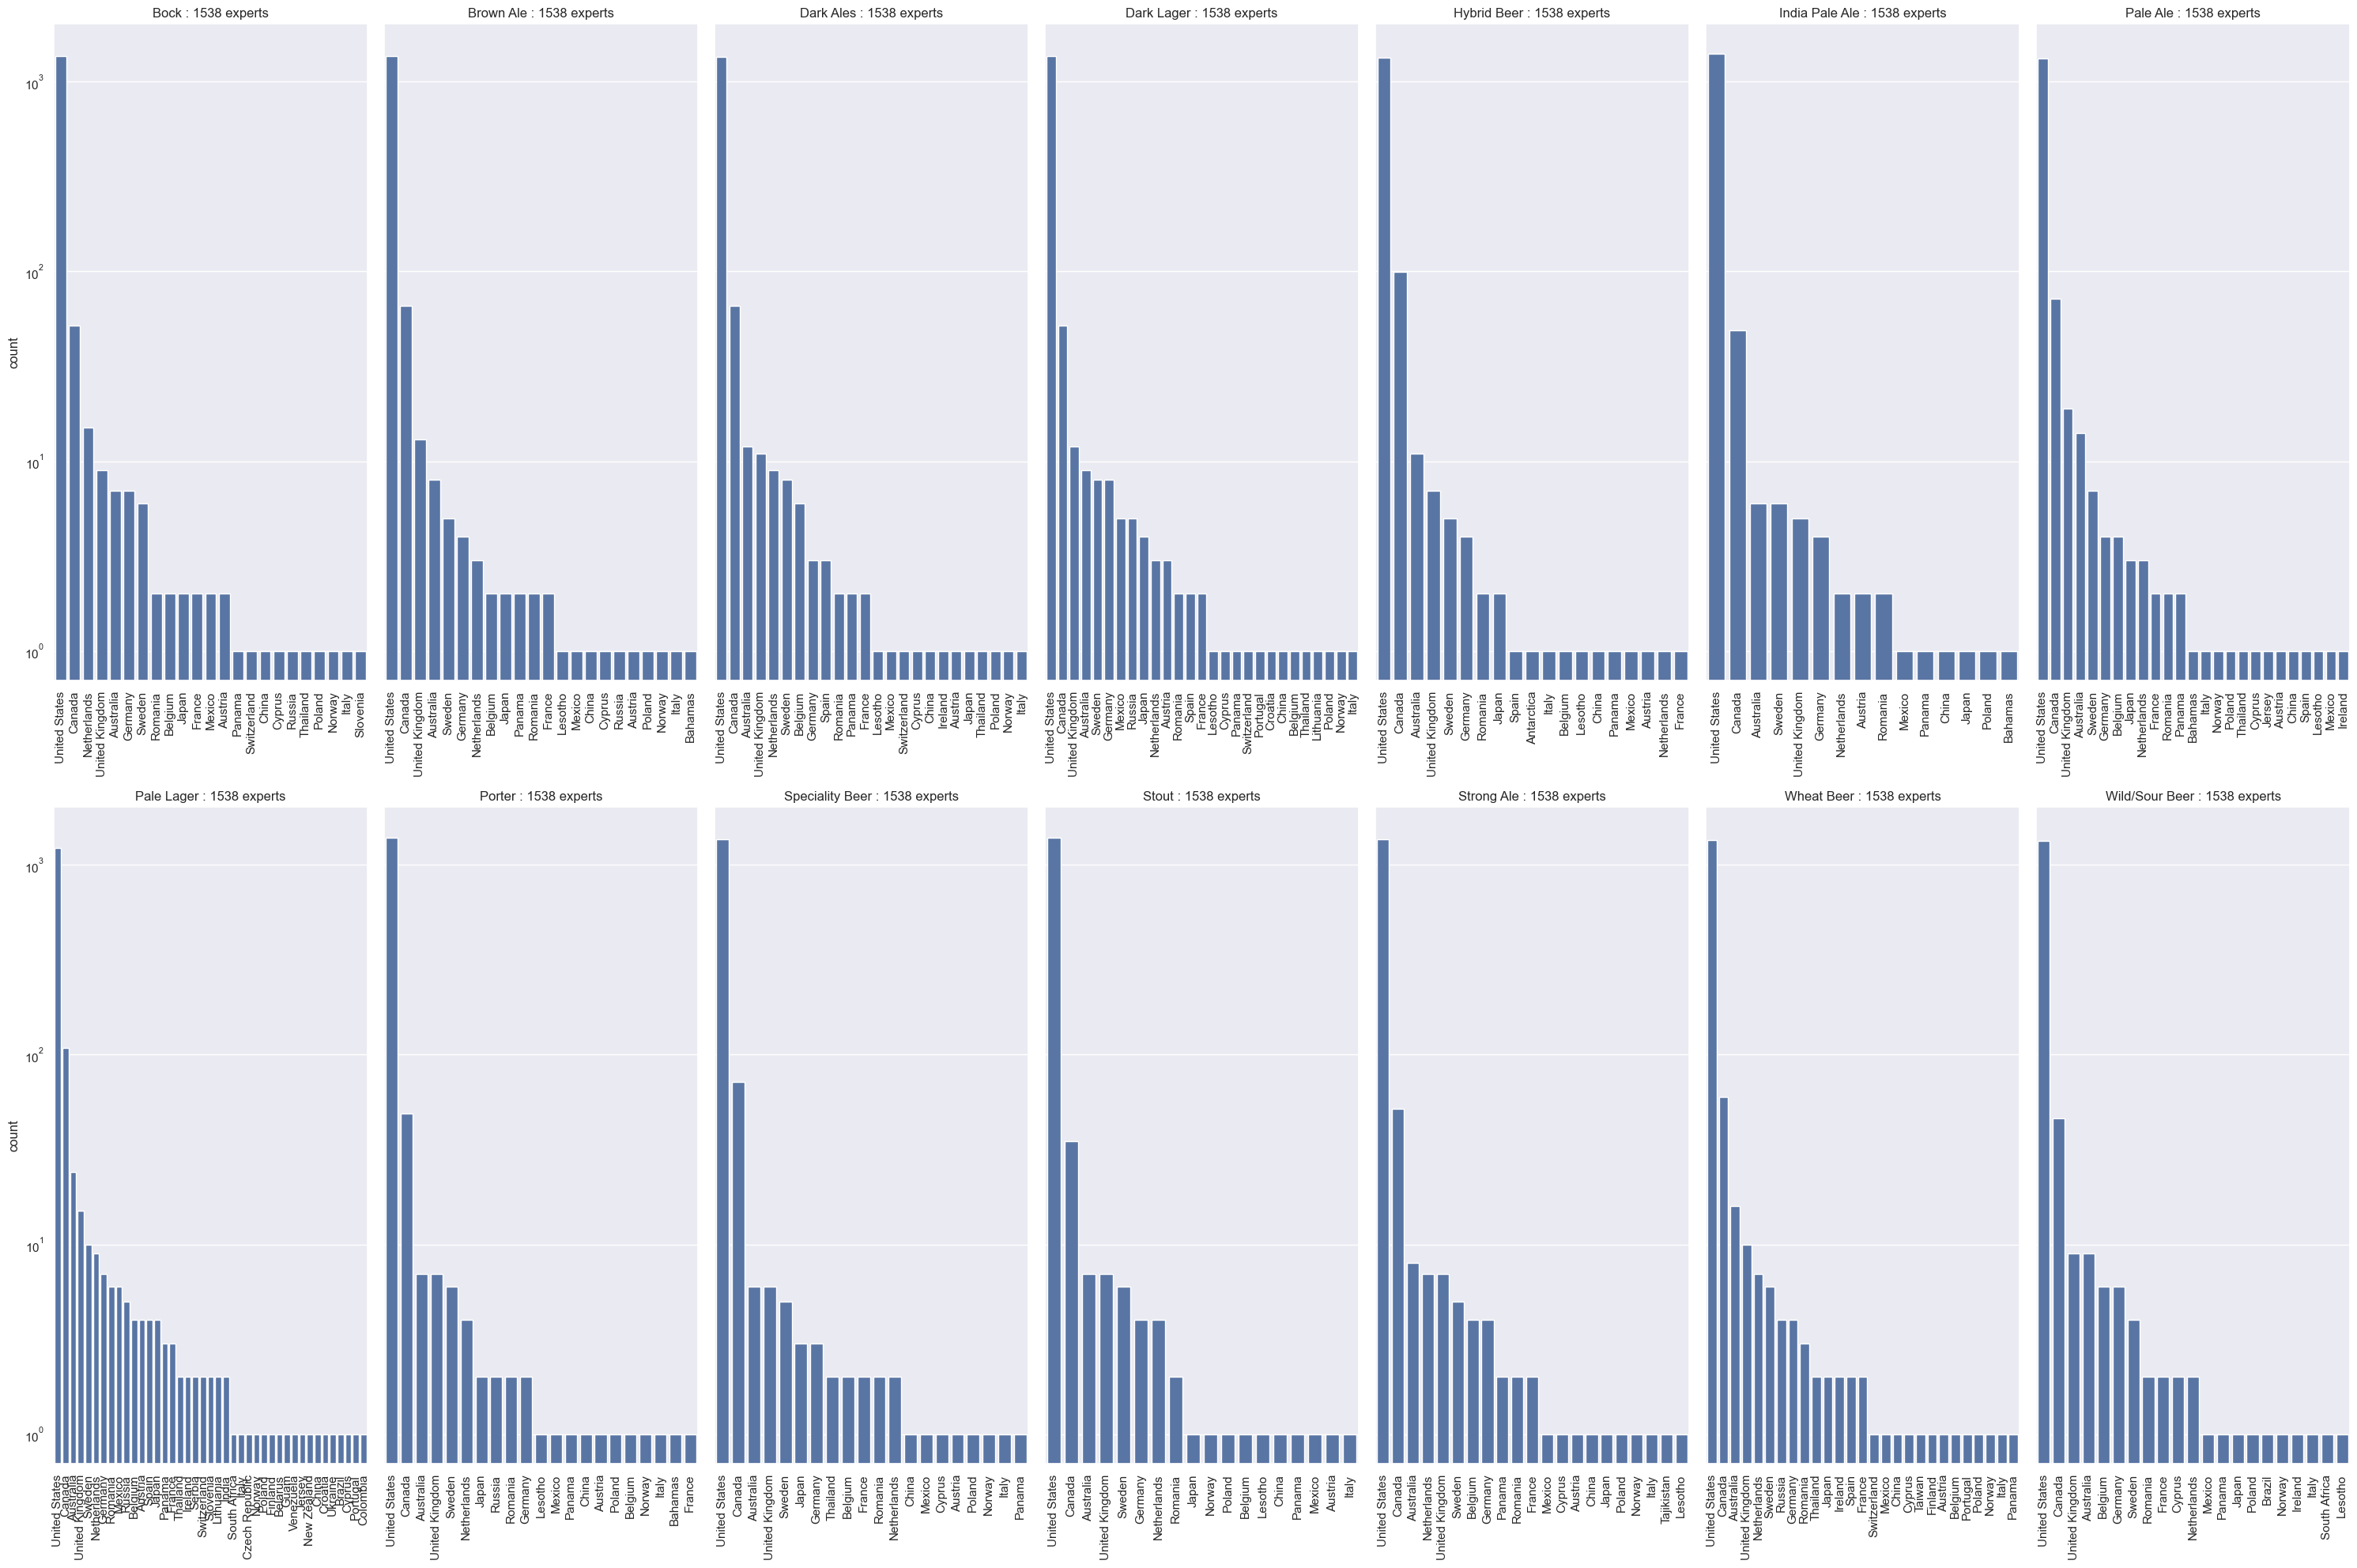

In [204]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)
for col_idx, col in enumerate(expert_columns):
    sns.barplot(df_expert_users[df_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> : United States, Canada, United Kingdom and Australia are the leading quartet for each beer style. However there are some interesting surprises in the following countries : ...

In [205]:
n_unique_experts_per_style.sort_values()

Bock_expert               1538
Brown Ale_expert          1538
Dark Ales_expert          1538
Dark Lager_expert         1538
Hybrid Beer_expert        1538
India Pale Ale_expert     1538
Pale Ale_expert           1538
Pale Lager_expert         1538
Porter_expert             1538
Speciality Beer_expert    1538
Stout_expert              1538
Strong Ale_expert         1538
Wheat Beer_expert         1538
Wild/Sour Beer_expert     1538
dtype: int64

In [206]:
df_ba_user_beer_style_past_ratings['date_month'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_ba_user_beer_style_past_ratings['date_quarter'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

In [207]:
df_expert_per_day = df_ba_user_beer_style_past_ratings[expert_columns+["date_month","user_id"]].groupby(["user_id","date_month"]).max().reset_index().iloc[:,1:].groupby("date_month").sum().reset_index()
df_expert_per_day_long = df_expert_per_day.melt(id_vars='date_month', var_name='Beer Style', value_name='Number of expert ratings')

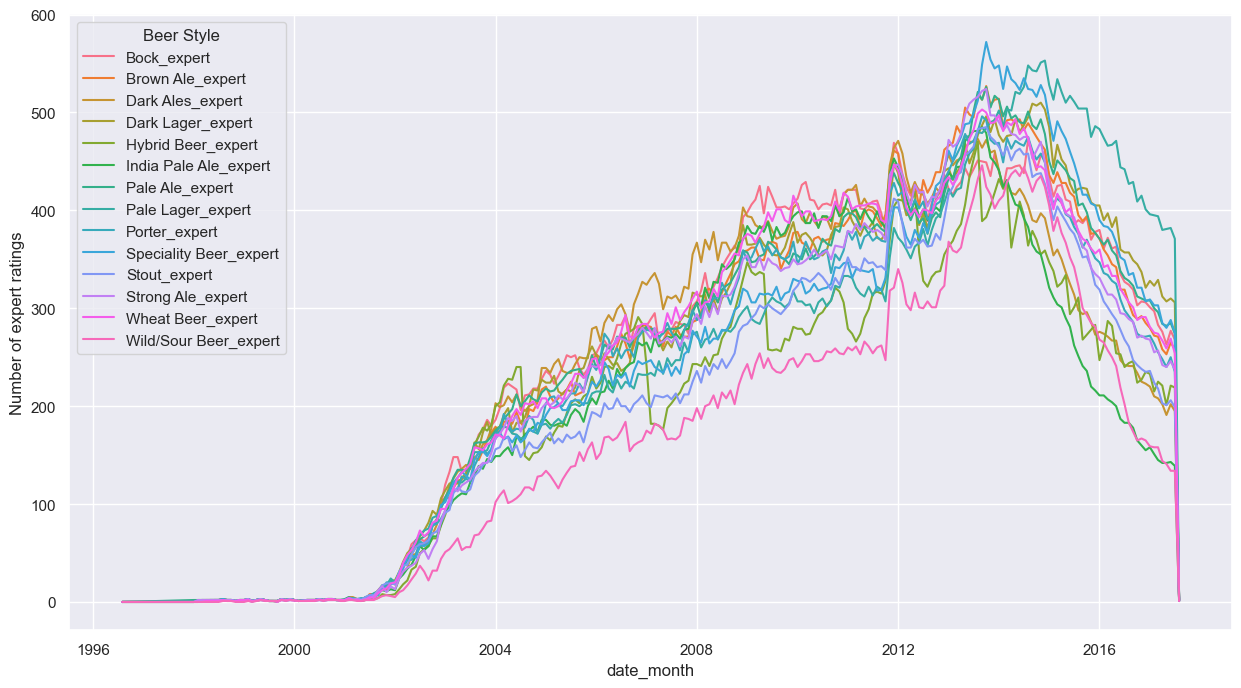

In [208]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long,x="date_month",y='Number of expert ratings', hue="Beer Style")
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [209]:
df_expert_ratings = df_ba_user_beer_style_past_ratings[expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_ba_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in expert_columns:
    beer_rated_by_experts = df_expert_ratings[(df_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_expert_ratings[(df_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_expert_ratings["beer_id"].isin(top_k_beers))]
    df_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_to_barplot = pd.concat(df_to_plots,axis=0)

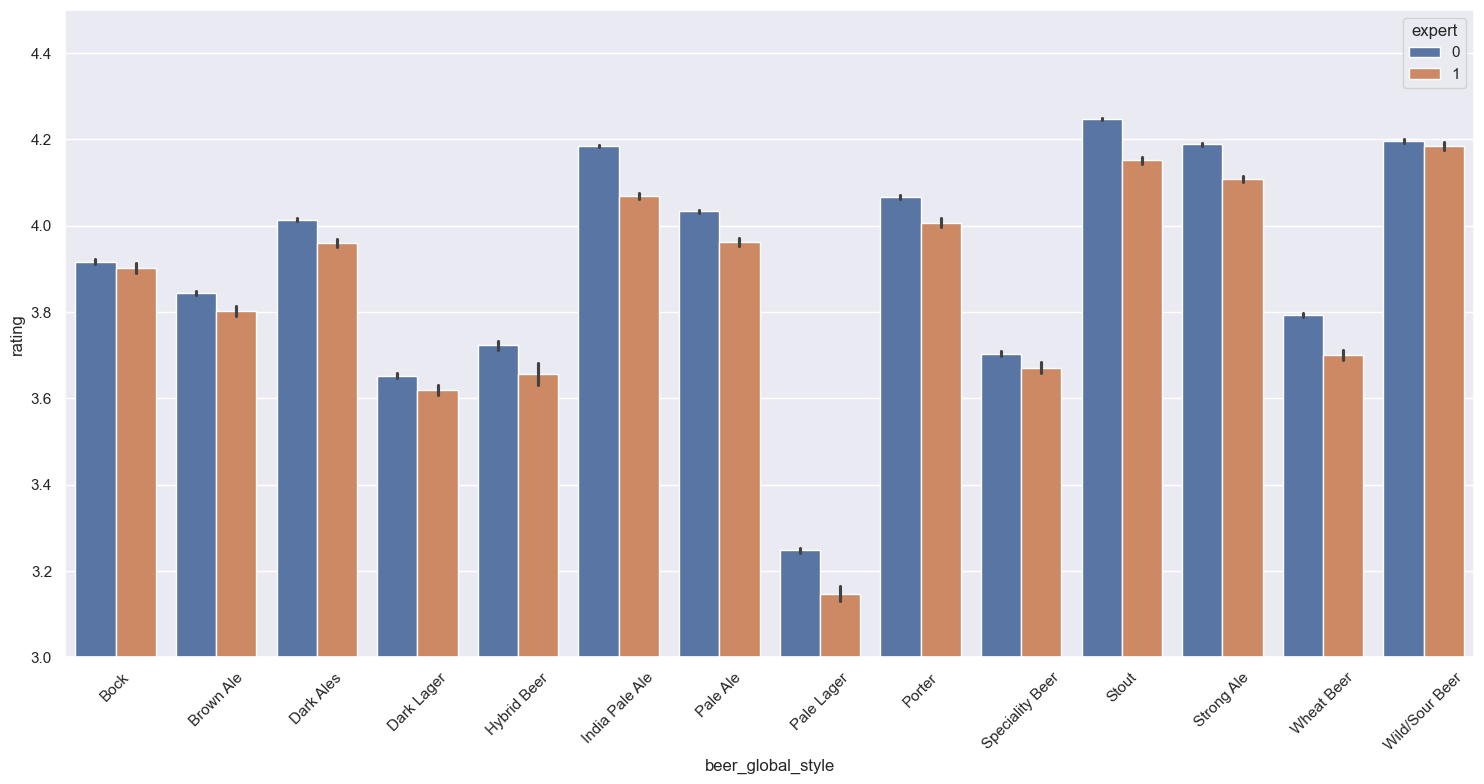

In [210]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_to_barplot,x="beer_global_style", y="rating", hue="expert")
#plt.errorbar(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], yerr=df_to_show["rating"]["sem"], fmt="none", c="black", capsize=5)
plt.xticks(rotation=45)
plt.ylim([3,4.5])
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [211]:
df_experts = df_ba_user_beer_style_past_ratings[expert_columns+["user_id","date_day"]]
df_ba_ratings = df_ba_ratings.dropna()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

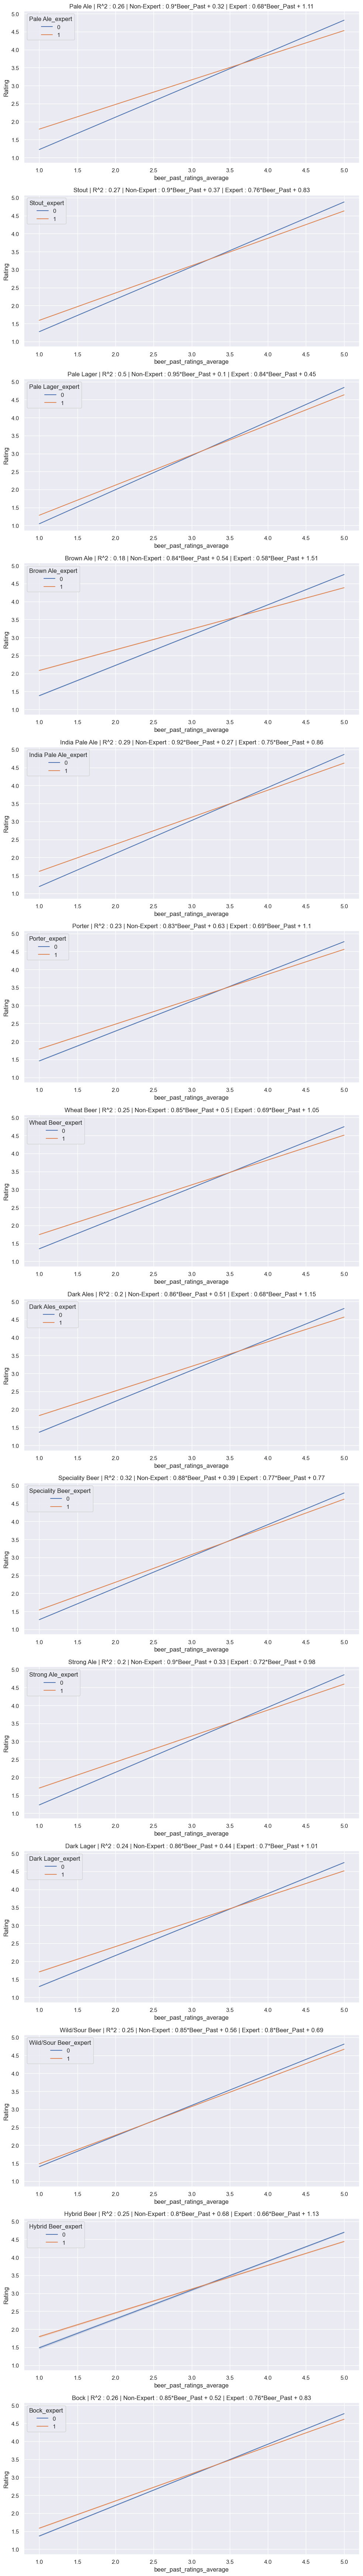

In [212]:
fig, axes = plt.subplots(14,1,figsize=(10,70),sharey=True)

for style_idx, beer_style in enumerate(df_ba_ratings["beer_global_style"].unique()):

    df_study = df_ba_ratings[df_ba_ratings["beer_global_style"] == beer_style][["user_id","date_day","beer_past_ratings_average","rating"]].merge(df_experts, how="left", on=["user_id","date_day"])
    X = df_study[[beer_style+"_expert", 'beer_past_ratings_average']]
    X.loc[:,"interaction"] = X[beer_style+"_expert"] * X["beer_past_ratings_average"]
    X.loc[:,"intercept"] = 1
    y = df_study['rating']
    reg = sm.OLS(y, X).fit()
    df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0],'intercept':[1,1,1,1]})
    #df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0]})

    prediction = reg.get_prediction(df_line)
    predicted_mean = prediction.predicted_mean
    conf_int = prediction.conf_int()

    df_line["predicted_rating"] = predicted_mean
    df_line["ci_lower"] = conf_int[:, 0]
    df_line["ci_upper"] = conf_int[:, 1]

    sns.lineplot(data = df_line, x = "beer_past_ratings_average", y = "predicted_rating", hue = beer_style+"_expert", legend=True, ax=axes[style_idx])
    axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past + {round(reg.params["intercept"],2)} | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params["intercept"] + reg.params[beer_style+"_expert"],2)}")
    #axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params[beer_style+"_expert"],2)}")
    axes[style_idx].set_ylabel("Rating")

    for expert in df_line[beer_style+"_expert"].unique():
        expert_data = df_line[df_line[beer_style+"_expert"] == expert]
        axes[style_idx].fill_between(
            expert_data["beer_past_ratings_average"], 
            expert_data["ci_lower"], 
            expert_data["ci_upper"], 
            alpha=0.2  # Adjust transparency of the shaded region
        )
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [213]:
df_expertise = df_expert_users.iloc[:,:-2].melt(id_vars="user_id",var_name="expertise",value_name="val")

In [214]:
df_expertise.drop(df_expertise[df_expertise["val"] == 0].index, axis=0, inplace=True)

In [215]:
df_expertise.loc[:,"expertise"] = df_expertise["expertise"].apply(lambda x: x.split("_")[0])

In [216]:
df_expertise.drop("val",axis=1,inplace=True)

In [217]:
df_co_experts_count = df_expertise.groupby("user_id").count().reset_index()

In [218]:
co_experts = df_co_experts_count[df_co_experts_count["expertise"] > 1]["user_id"]

In [219]:
df_coexpertise = df_expertise[df_expertise["user_id"].isin(co_experts)].merge(df_expertise[df_expertise["user_id"].isin(co_experts)], on="user_id", how="left", suffixes=["_a","_b"])

In [220]:
df_coexpertise.drop(df_coexpertise[df_coexpertise["expertise_a"] == df_coexpertise["expertise_b"]].index,axis=0,inplace=True)

In [221]:
df_soloexpertise = df_expertise[~df_expertise["user_id"].isin(co_experts)]

In [222]:
df_soloexpertise.rename(columns={"expertise":"expertise_a"},inplace=True)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/901004683.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
df_soloexpertise.loc[:,"expertise_b"] = df_soloexpertise["expertise_a"]

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/246054117.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
df_final_expertise = pd.concat([df_soloexpertise,df_coexpertise],axis=0)

In [225]:
df_final_expertise.groupby(["expertise_a","expertise_b"]).count().reset_index().to_csv("./coexpertise.csv",index=False)

In [226]:
df_coexpertise_count = df_final_expertise.groupby(["expertise_a","expertise_b"]).count().reset_index()

In [227]:
df_coexpertise_count.loc[df_coexpertise_count[["expertise_a","user_id"]].groupby("expertise_a").idxmax().reset_index()["user_id"]].to_csv("./coexpertise_bis.csv",index=False)

In [228]:
df_final_expertise.to_csv("./coexpertise.csv",index=False)

# Graphical Approach of experts

## Shell Layout with nodes as expertise kind and beer styles

In [229]:
import networkx as nx
import community as community_louvain

MIN_EXPERT = 70
SIZE_STYLE = 1000
SIZE_EXPERT_MIN = 500

In [230]:
G = nx.Graph()

styles = df_ba_ratings["beer_global_style"].unique()
styles.sort()

styles_total = df_expert_users.iloc[:,1:-2].sum().to_dict()

user_expertise = dict()

for row in df_expert_users.iterrows():
    expertise = []
    for style_idx, style in enumerate(styles):
        if row[1][style_idx + 1] == 1:
            expertise.append(style)
    user_expertise[row[1][0]] = expertise

expertise_kinds = []
for val in user_expertise.values():
    if val not in expertise_kinds:
        expertise_kinds.append(val)

edge_sizes = []
for i, expertise in enumerate(expertise_kinds):
    size = list(user_expertise.values()).count(expertise)
    if size >= MIN_EXPERT and len(expertise) >= 2:
        G.add_node(str(i))
        for style in expertise:
            G.add_edge(style,str(i))
            expert_share = 100 * (size / styles_total[style+"_expert"])
            edge_sizes.append(expert_share)

colors = ["red","green","blue","orange","purple","cyan","magenta","yellow","pink","lime","teal","brown","gray","olive"]
kind_to_color_bis = {styles[i]:colors[i] for i in range(len(styles))}

edge_colors = []
for u,v in G.edges():
    if u in styles:
        edge_colors.append(kind_to_color_bis[u])
    else:
        edge_colors.append(kind_to_color_bis[v])

node_sizes = []
node_colors = []
experts = []
for node in G.nodes():
    if node in styles:
        node_sizes.append(SIZE_STYLE)
        node_colors.append(kind_to_color_bis[node])
    else:
        experts.append(node)
        expertises = expertise_kinds[int(node)]
        node_sizes.append(SIZE_EXPERT_MIN + list(user_expertise.values()).count(expertises))
        node_colors.append("black")

shells = [styles, experts]
pos = nx.shell_layout(G, shells)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/4011270081.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/4011270081.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



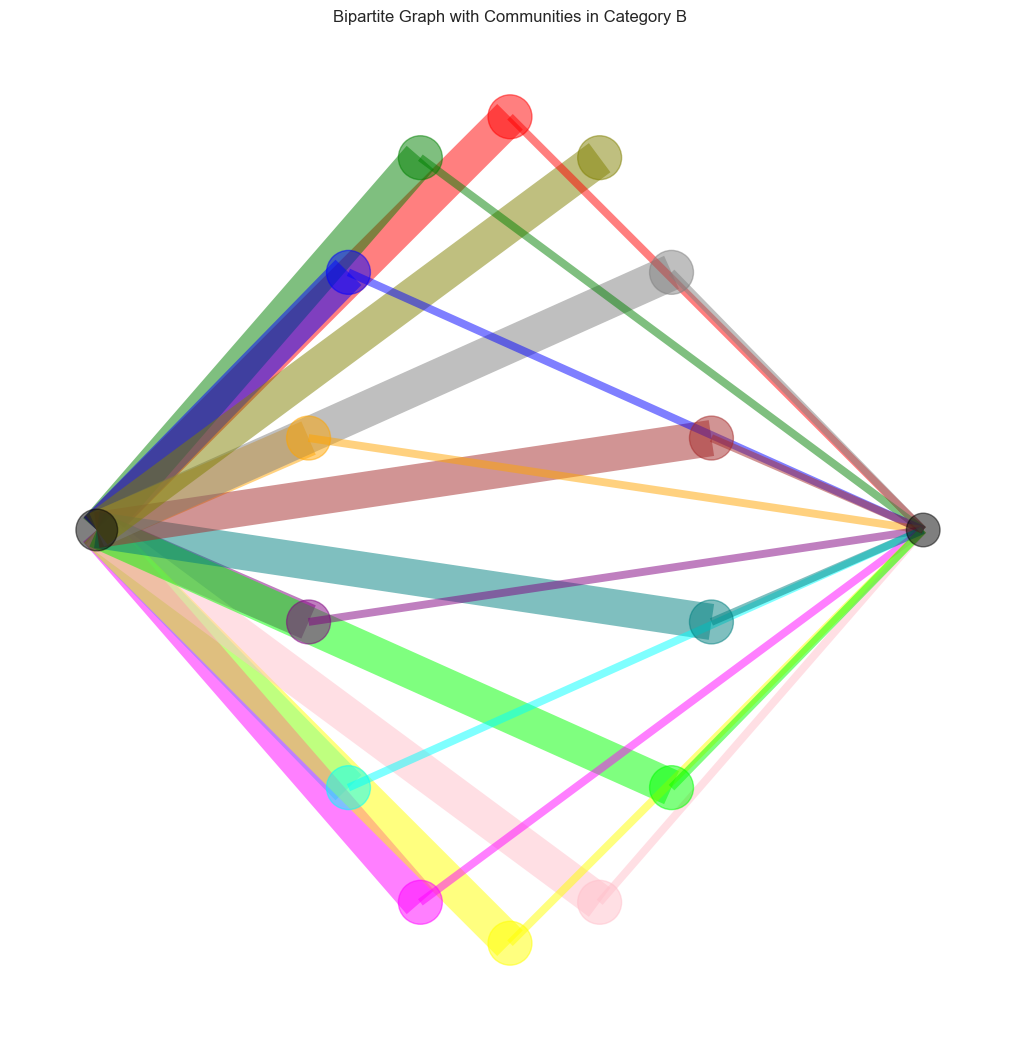

In [231]:
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_sizes,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

## Spring layout with nodes as users and beer styles

In [232]:
G_bis = nx.Graph()

styles = df_ba_ratings["beer_global_style"].unique()
styles.sort()

G_bis.add_nodes_from(styles)
G_bis.add_nodes_from(df_expert_users["user_id"])

df_expert_users_renamed = df_expert_users.rename(columns={style+"_expert":style for style in styles}).iloc[:,:-2]
df_edges = df_expert_users_renamed.melt(id_vars="user_id",var_name="style",value_name="edge")
G_bis.add_edges_from(df_edges[df_edges["edge"] == 1][["user_id","style"]].values)

nodes_to_remove = [node for node in G_bis.nodes() if G_bis.degree(node) == 1]

G_bis.remove_nodes_from(nodes_to_remove)

node_sizes = []
node_colors = []
for node in G_bis.nodes():
    if node in styles:
        node_sizes.append(500)
        node_colors.append("red")
    else:
        node_colors.append("blue")
        node_sizes.append(10)

user_nodes = [node for node in G_bis.nodes() if node in df_expert_users_renamed["user_id"]]
style_nodes = [node for node in G_bis.nodes() if node in styles]

all_pos = nx.spring_layout(G_bis, seed=42)

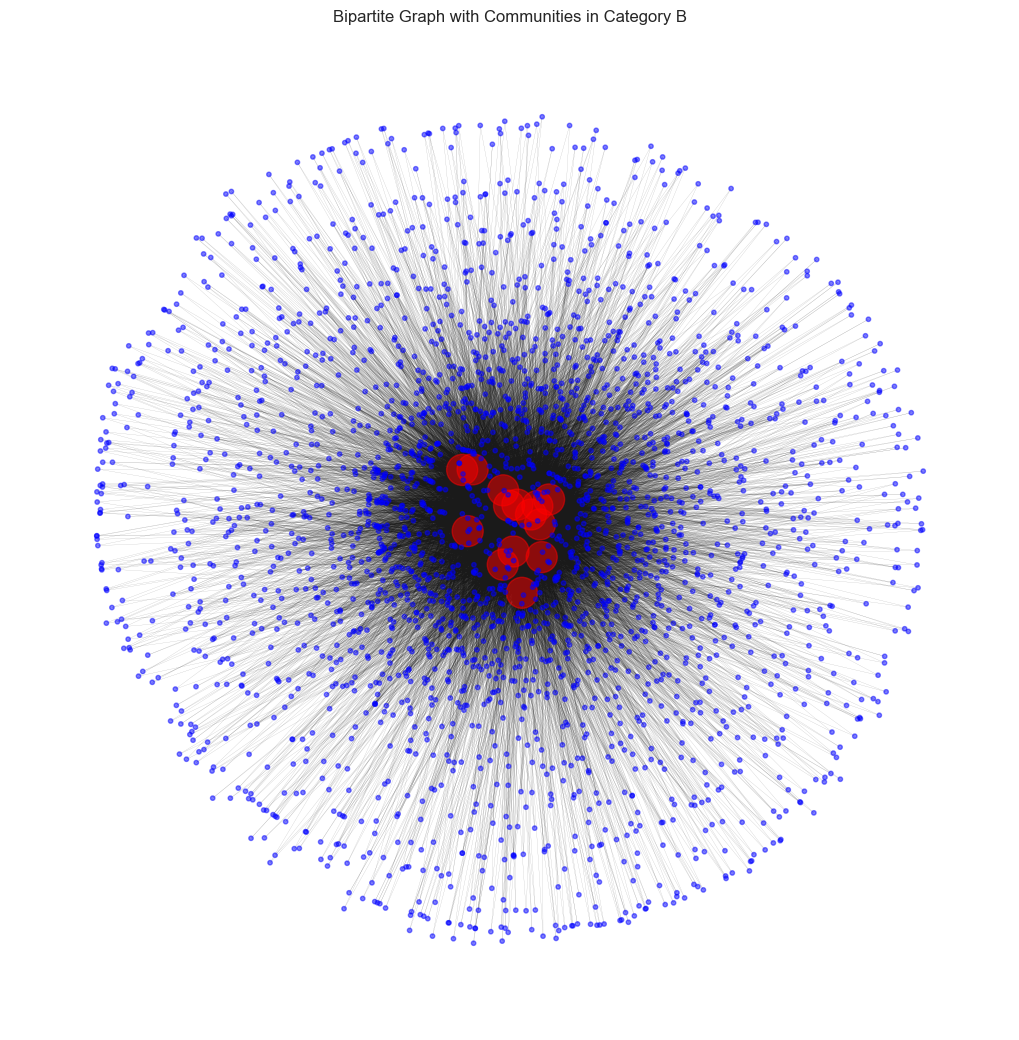

In [233]:
plt.figure(figsize=(10, 10))
nx.draw(
    G_bis,
    all_pos,
    node_size=node_sizes,
    node_color=node_colors,
    width=0.1,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

# Rate Beer

In [234]:
df_rb_user_beer_style_past_ratings = pd.read_csv("../data/rate_beer/user_beer_style_past_ratings.csv")
df_rb_ratings = pd.read_csv("../data/rate_beer/ratings.csv")

In [235]:
df_rb_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_rb_ratings["user_beer_style_past_ratings_count"] - 1
df_rb_ratings.loc[df_rb_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_rb_ratings['date_day'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.round('D')
df_rb_ratings.drop(df_rb_ratings[df_rb_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

#To preprocess once and for all
df_rb_user_beer_style_past_ratings['date_day'] = pd.to_datetime(df_rb_user_beer_style_past_ratings['date'], unit="s").dt.round('D')

In [236]:
df_current_beer_per_style = number_of_beer_per_style(df_rb_ratings)

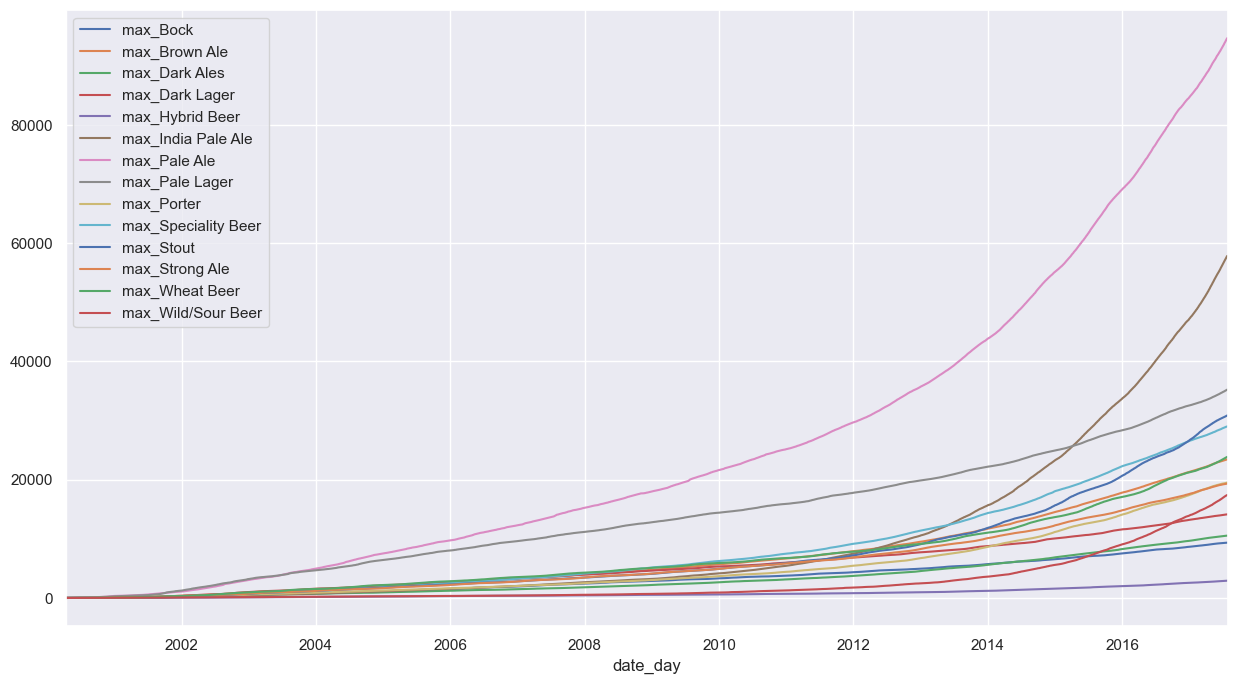

In [237]:
df_current_beer_per_style.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

In [238]:
average_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "average" in col]
count_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style.columns if "max" in col]

In [239]:
df_rb_user_beer_style_past_ratings = add_global_knowledge(df_current_beer_per_style, df_rb_user_beer_style_past_ratings, count_columns)
df_rb_user_beer_style_past_ratings, df_local_knowledge = add_local_knowledge(df_current_beer_per_style, df_rb_user_beer_style_past_ratings, max_columns, count_columns)

df_knowledge = df_rb_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2

df_knowledge = df_knowledge.drop(df_knowledge[df_knowledge["local_knowledge"] == 0].index, axis=0)

df_prime_knowledge = df_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/beer_knowledge.py:105: RuntimeWarning:

invalid value encountered in divide

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1715063475.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



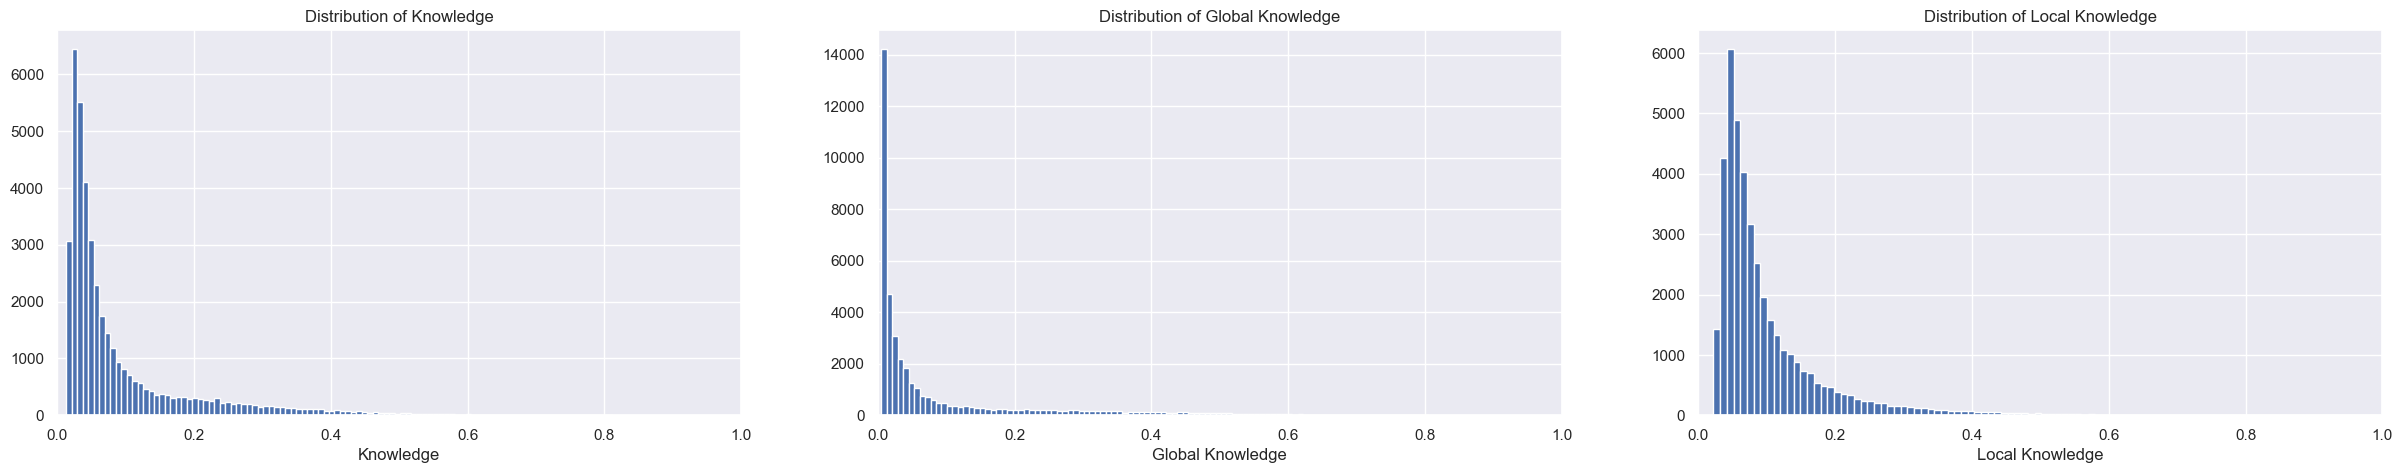

In [240]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_prime_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_prime_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_prime_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

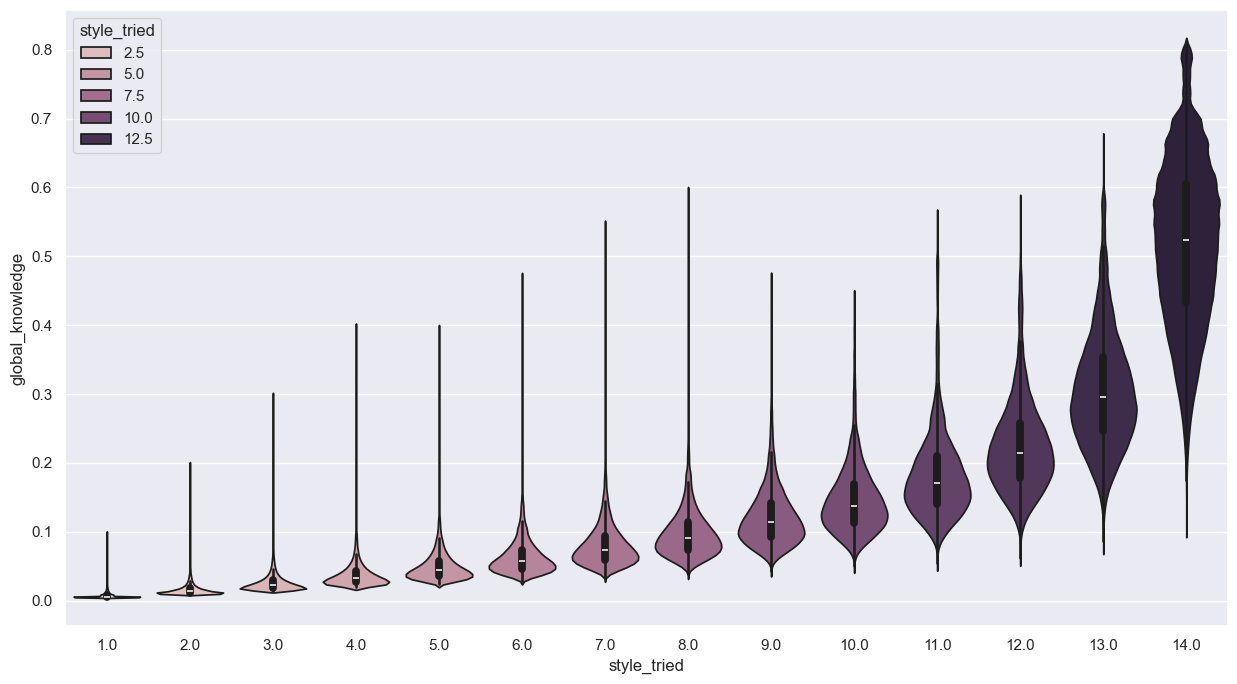

In [241]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_knowledge["style_tried"],y=df_knowledge["global_knowledge"],hue=df_knowledge["style_tried"])
plt.show()

In [268]:
df_local_knowledge.iloc[:,:-1].groupby("user_id").max().reset_index()

user_id      Bock  Brown Ale  Dark Ales  Dark Lager  Hybrid Beer  \
0            2  0.186563   1.000000   0.325487    0.500000     0.793701   
1            3  0.793701   1.000000   0.401939    0.425290     1.000000   
2            7  0.425290   0.292402   0.793701    0.277098     0.000000   
3           10  0.000000   0.000000   0.000000    0.374756     0.000000   
4           15       NaN   0.000000        NaN         NaN          NaN   
...        ...       ...        ...        ...         ...          ...   
69059   489662  0.000000   0.000000   0.000000    0.000000     0.000000   
69060   489669  0.000000   0.000000   0.000000    0.000000     0.000000   
69061   489869  0.000000   0.000000   0.000000    0.000000     0.000000   
69062   489908  0.000000   0.000000   0.045604    0.000000     0.000000   
69063   489914  0.000000   0.000000   0.000000    0.000000     0.000000   

       India Pale Ale  Pale Ale  Pale Lager    Porter  Speciality Beer  \
0                 1.0  0.782027    0.459113  0.793701         0.167708   
1                 0.5  0.629961    0.574071  1.000000         1.000000   
2                 0.0  0.228336    0.219933  0.298760         0.489997   
3                 0.0  0.240375    0.000000  0.000000         0.000000   
4                 NaN       NaN         NaN       NaN              NaN   
...               ...       ...         ...       ...              ...   
69059             0.0  0.000000    0.000000  0.000000         0.000000   
69060             0.0  0.000000    0.000000  0.000000         0.000000   
69061             0.0  0.000000    0.000000  0.000000         0.000000   
69062             0.0  0.000000    0.000000  0.000000         0.000000   
69063             0.0  0.000000    0.000000  0.000000         0.000000   

          Stout  Strong Ale  Wheat Beer  Wild/Sour Beer  
0      0.550321    0.314980    0.489997        0.374756  
1      1.000000    0.584804    0.782974        0.522758  
2      0.305711    0.341995    0.464159        0.833450  
3      0.351634    0.000000    0.362460        0.000000  
4           NaN         NaN    0.000000             NaN  
...         ...         ...         ...             ...  
69059  0.031873    0.000000    0.000000        0.000000  
69060  0.000000    0.000000    0.000000        0.000000  
69061  0.000000    0.000000    0.000000        0.000000  
69062  0.000000    0.000000    0.000000        0.073779  
69063  0.000000    0.000000    0.000000        0.000000  

[69064 rows x 15 columns]

In [276]:
df_local_knowledge[df_local_knowledge["user_id"] == 2].sort_values(by="date_day")

Bock  Brown Ale  Dark Ales  Dark Lager  Hybrid Beer  India Pale Ale  \
10       NaN   0.000000        NaN         NaN          NaN             NaN   
16       NaN   0.000000        NaN         NaN          NaN             NaN   
15  0.000000   1.000000   0.000000         NaN          NaN        1.000000   
12  0.000000   1.000000   0.000000         NaN          NaN        0.000000   
5   0.000000   0.000000   0.000000         NaN          NaN        0.000000   
21  0.000000   1.000000   0.000000         NaN          NaN        1.000000   
35  0.000000   1.000000   0.000000         NaN          NaN        1.000000   
29  0.000000   1.000000   0.000000    0.000000          NaN        0.928318   
8   0.000000   0.793701   0.000000    0.000000          NaN        0.584804   
9   0.000000   0.793701   0.000000    0.000000          NaN        0.736806   
20  0.000000   1.000000   0.000000    0.000000          NaN        0.928318   
3   0.000000   0.793701   0.000000    0.000000          NaN        0.584804   
13  0.000000   0.793701   0.000000    0.000000          NaN        0.736806   
14  0.000000   0.793701   0.000000    0.000000          NaN        0.843433   
17  0.000000   1.000000   0.000000    0.000000          NaN        0.843433   
18  0.000000   1.000000   0.000000    0.000000          NaN        0.843433   
19  0.000000   1.000000   0.000000    0.000000          NaN        0.928318   
4   0.000000   0.793701   0.000000    0.000000          NaN        0.584804   
24  0.000000   1.000000   0.000000    0.000000          NaN        0.928318   
22  0.000000   0.873580   0.000000    0.000000          NaN        0.873580   
38  0.000000   0.793701   0.000000    0.000000          NaN        0.893904   
27  0.000000   0.736806   0.000000    0.000000          NaN        0.893904   
0   0.000000   0.736806   0.000000    0.000000          NaN        0.893904   
25  0.000000   0.736806   0.000000    0.000000          NaN        0.893904   
26  0.000000   0.736806   0.000000    0.000000          NaN        0.893904   
1   0.000000   0.693361   0.000000    0.500000          NaN        0.893904   
36  0.000000   0.693361   0.000000    0.500000          NaN        0.893904   
30  0.000000   0.693361   0.000000    0.500000          NaN        0.893904   
23  0.000000   0.629961   0.000000    0.388911     0.000000        0.854988   
41  0.000000   0.629961   0.000000    0.381571     0.793701        0.822071   
42  0.000000   0.605707   0.000000    0.374756     0.793701        0.709492   
33  0.000000   0.605707   0.000000    0.362460     0.793701        0.693361   
2   0.000000   0.605707   0.000000    0.362460     0.793701        0.693361   
31  0.000000   0.605707   0.000000    0.351634     0.693361        0.665029   
43  0.000000   0.414913   0.000000    0.325487     0.693361        0.592816   
28  0.000000   0.401072   0.000000    0.305711     0.693361        0.592816   
44  0.000000   0.374756   0.000000    0.371525     0.629961        0.563124   
46  0.000000   0.374756   0.000000    0.371525     0.629961        0.563124   
32  0.000000   0.374756   0.000000    0.371525     0.629961        0.563124   
37  0.000000   0.374756   0.000000    0.371525     0.584804        0.598408   
40  0.000000   0.344306   0.000000    0.349122     0.550321        0.584804   
39  0.000000   0.339745   0.325487    0.346681     0.550321        0.572357   
11  0.000000   0.302853   0.292402    0.297444     0.464159        0.522758   
34  0.000000   0.296151   0.285437    0.291193     0.464159        0.514714   
6   0.186563   0.187173   0.175185    0.185962     0.300100        0.331973   
7   0.186563   0.187173   0.175185    0.185962     0.300100        0.331973   
47  0.186563   0.187173   0.175185    0.185962     0.300100        0.331973   
48  0.186563   0.187173   0.175185    0.185962     0.300100        0.331973   
45  0.132283   0.136176   0.134173    0.132437     0.223144        0.245199   

    Pale Ale  Pale Lager    Porter  Speciality Beer     S

In [275]:
df_rb_ratings[df_rb_ratings["user_id"] == 2].sort_values(by="date_day")

user_id  beer_id  brewery_id        date  rating  overall  aroma  \
38        2     1267          13   957952800     4.7     4.75    4.5   
25        2      695         111   959248800     4.2     4.25    3.5   
1         2       47          11   959508000     3.9     3.75    3.5   
30        2      748         121   959508000     3.4     3.25    2.0   
36        2     1100       10964   959508000     3.1     3.25    3.0   
2         2       48          11   961927200     4.1     4.00    4.0   
33        2     1088         175   961927200     4.4     4.25    5.0   
31        2      839         137   962532000     4.7     4.50    5.0   
39        2     1402         751   971949600     3.4     3.50    3.5   
11        2      288          55   975236400     3.6     3.50    4.0   
6         2      172          34  1005562800     4.1     4.25    4.0   
47        2    10215          34  1005562800     3.4     3.50    3.0   
48        2    10526        1928  1005562800     2.1     2.00    2.0   
45        2     3304        6033  1035367200     4.4     4.50    4.5   

    appearance  palate  taste  \
38         5.0     5.0    4.5   
25         4.0     5.0    4.5   
1          4.0     4.0    4.5   
30         5.0     5.0    3.5   
36         3.0     3.0    3.0   
2          5.0     4.0    4.0   
33         4.0     4.0    4.5   
31         5.0     5.0    4.5   
39         2.0     4.0    3.5   
11         4.0     4.0    3.0   
6          4.0     4.0    4.0   
47         4.0     4.0    3.0   
48         3.0     3.0    1.5   
45         4.0     4.0    4.5   

                                                 text  \
38  Every time I have one of these, I draw a littl...   
25  Excellent easy-drinking ale.  A new regular in...   
1   Not as impressive as Iâd hoped, but very fla...   
30  I remember hating this beer before I sat down ...   
36  Not hoppy enough for a beer that has âHopâ...   
2   Very nice porter, but so far nothing compares ...   
33  I knew this would be a good beer just from the...   
31  Had this on draught, and it was absolutely won...   
39  I thought this was a pretty good beer.  Maybe ...   
11  Better aroma than flavor, but very good body a...   
6   The more I drink this, the more I like it.  I ...   
47  Another good beer from Sweetwater.  I agree wi...   
48  Not a good beer.  The ginger flavor was a bit ...   
45      One of the better beers Iâve had recently.    

    user_past_ratings_count  user_past_ratings_average  \
38                       20                   3.830000   
25                       23                   3.739130   
1                        25                   3.768000   
30                       26                   3.773077   
36                       27                   3.759259   
2                        31                   3.725806   
33                       32                   3.737500   
31                       33                   3.757576   
39                       41                   3.790244   
11                       42                   3.780952   
6                        44                   3.790909   
47                       46                   3.804348   
48                       47                   3.795745   
45                       48                   3.760417   

    beer_past_ratings_count  beer_past_ratings_average beer_global_style  \
38                        2                   4.500000             Stout   
25                        1                   4.200000          Pale Ale   
1                         2                   4.450000          Pale Ale   
30                        1                   3.500000        Pale Lager   
36                        3                   4.233333          Pale Ale   
2                         3                   4.500000            Porter   
33                        1                   3.500000        Wheat Beer   
31                        1                   4.400000             Stout   
39              

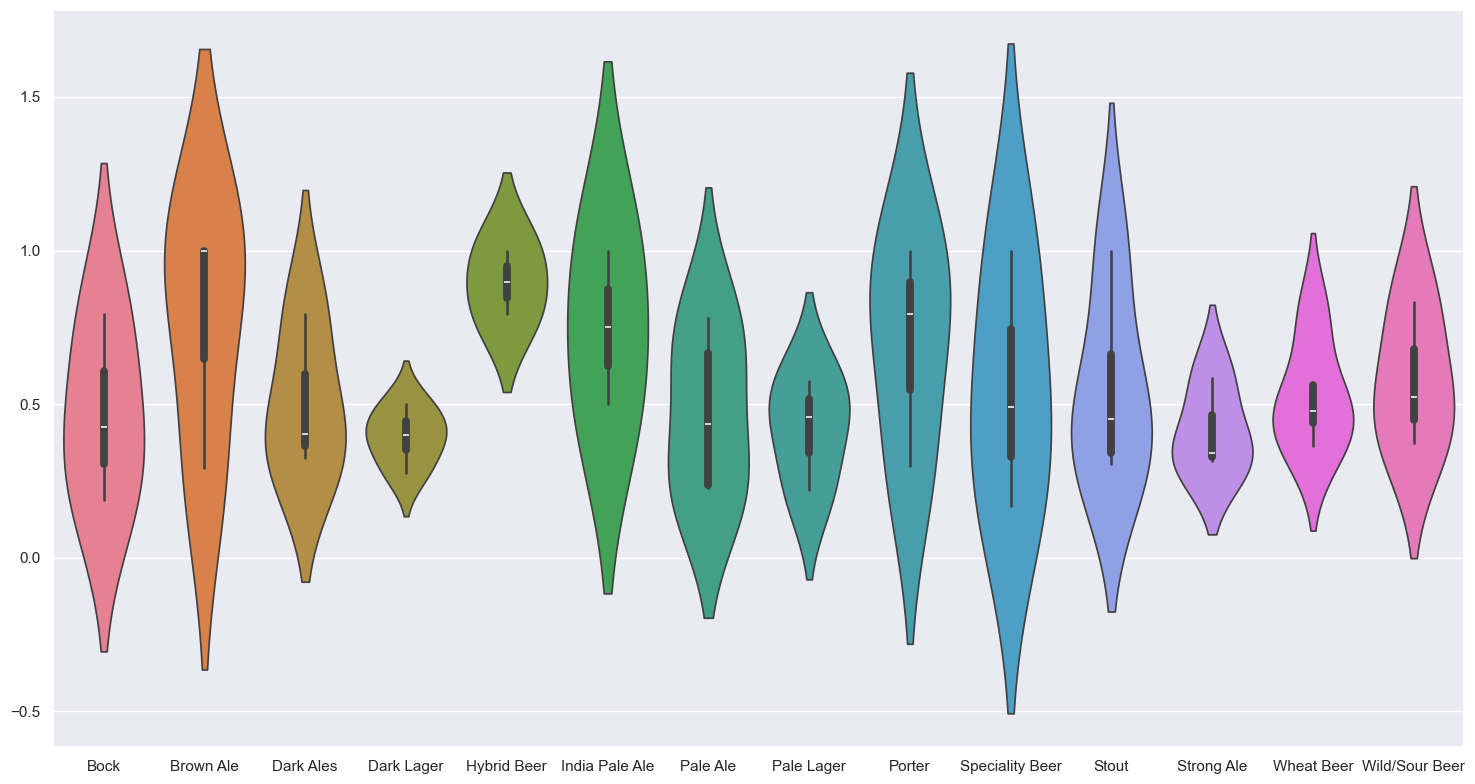

In [242]:
plt.figure(figsize=(15,8))
sns.violinplot(df_local_knowledge.iloc[:,:-1].groupby("user_id").max().reset_index().replace(0,np.nan).head().iloc[:,1:])
plt.tight_layout()
plt.show()

# Experts

In [243]:
df_rb_user_beer_style_past_ratings, df_local_knowledge_quantile_expert = add_experts(df_local_knowledge, df_rb_user_beer_style_past_ratings,0.99)

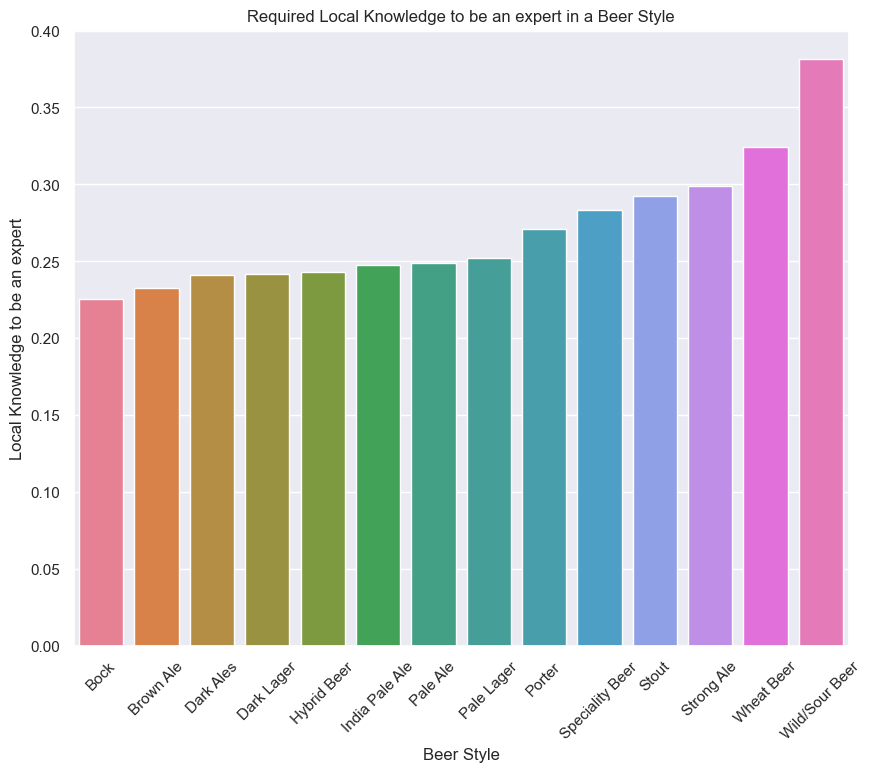

In [244]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_local_knowledge_quantile_expert.index, y=df_local_knowledge_quantile_expert.sort_values(), hue=df_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.ylabel("Local Knowledge to be an expert")
plt.xlabel("Beer Style")
plt.title("Required Local Knowledge to be an expert in a Beer Style")
plt.show()

In [245]:
max_available_beer_per_day = df_rb_user_beer_style_past_ratings[max_columns+["date_day"]].groupby("date_day").max().reset_index()
max_available_beer_per_day.columns = ["date_day"] + df_local_knowledge_quantile_expert.index.to_list()
max_available_beer_per_day.iloc[:,1:] = max_available_beer_per_day.iloc[:,1:] * np.pow(df_local_knowledge_quantile_expert,3)
df_beer_required_to_be_expert_long = max_available_beer_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Beers to be expert')

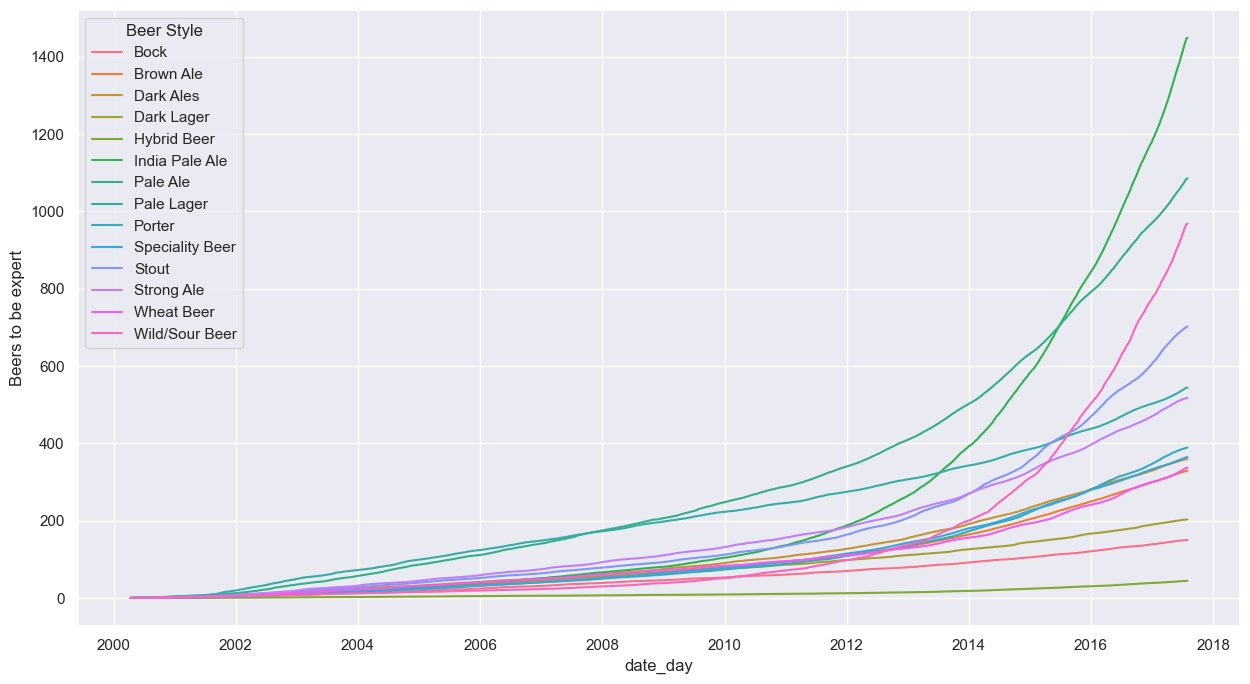

In [246]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_beer_required_to_be_expert_long["date_day"],y=df_beer_required_to_be_expert_long["Beers to be expert"], hue=df_beer_required_to_be_expert_long["Beer Style"])
plt.show()

In [247]:
expert_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "expert" in col]
n_unique_experts_per_style = df_rb_user_beer_style_past_ratings[expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_rb_user_beer_style_past_ratings.loc[:,"isExpert"] = df_rb_user_beer_style_past_ratings[expert_columns].sum(axis=1)
df_expert_users = df_rb_user_beer_style_past_ratings.loc[df_rb_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"]+expert_columns].groupby("user_id").max().reset_index().merge(df_rb_users[["user_id","user_country"]], how="left", on="user_id")

In [248]:
df_expert_users = df_expert_users.merge(df_rb_users[["user_id","user_country_code"]], how="left", on="user_id")

In [249]:
df_count_exp = df_expert_users["user_country_code"].value_counts().reset_index()
df_count_exp["log_count"] = np.log(df_count_exp["count"])

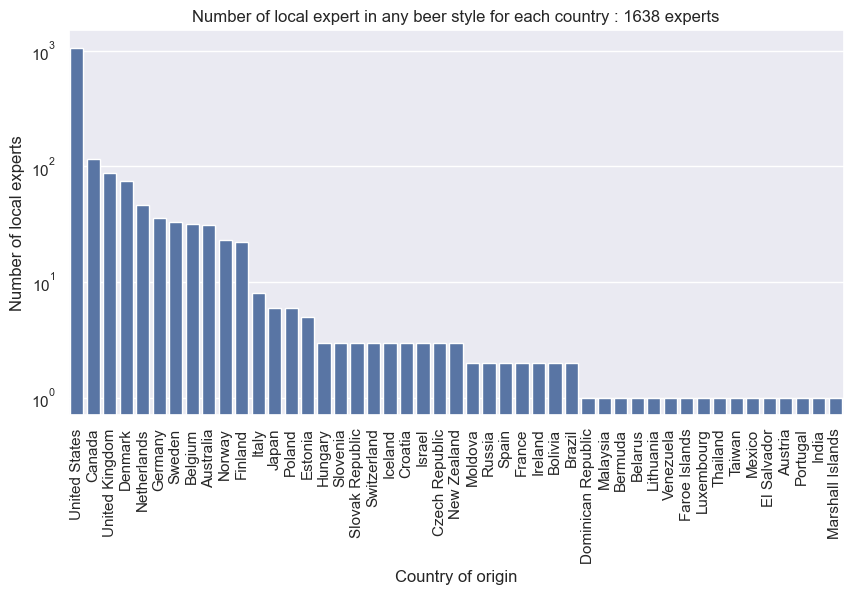

In [250]:
plt.figure(figsize=(10,5))
sns.barplot(df_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.title(f"Number of local expert in any beer style for each country : {df_expert_users["user_country"].value_counts().sum().item()} experts")
plt.yscale("log")
plt.show()

In [251]:
import plotly.io as pio
pio.renderers.default = 'browser'  # Use browser for rendering

In [252]:
fig = px.choropleth(
    df_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)


# Update layout for better visualization
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type='mercator')
)

# Display the map
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of t

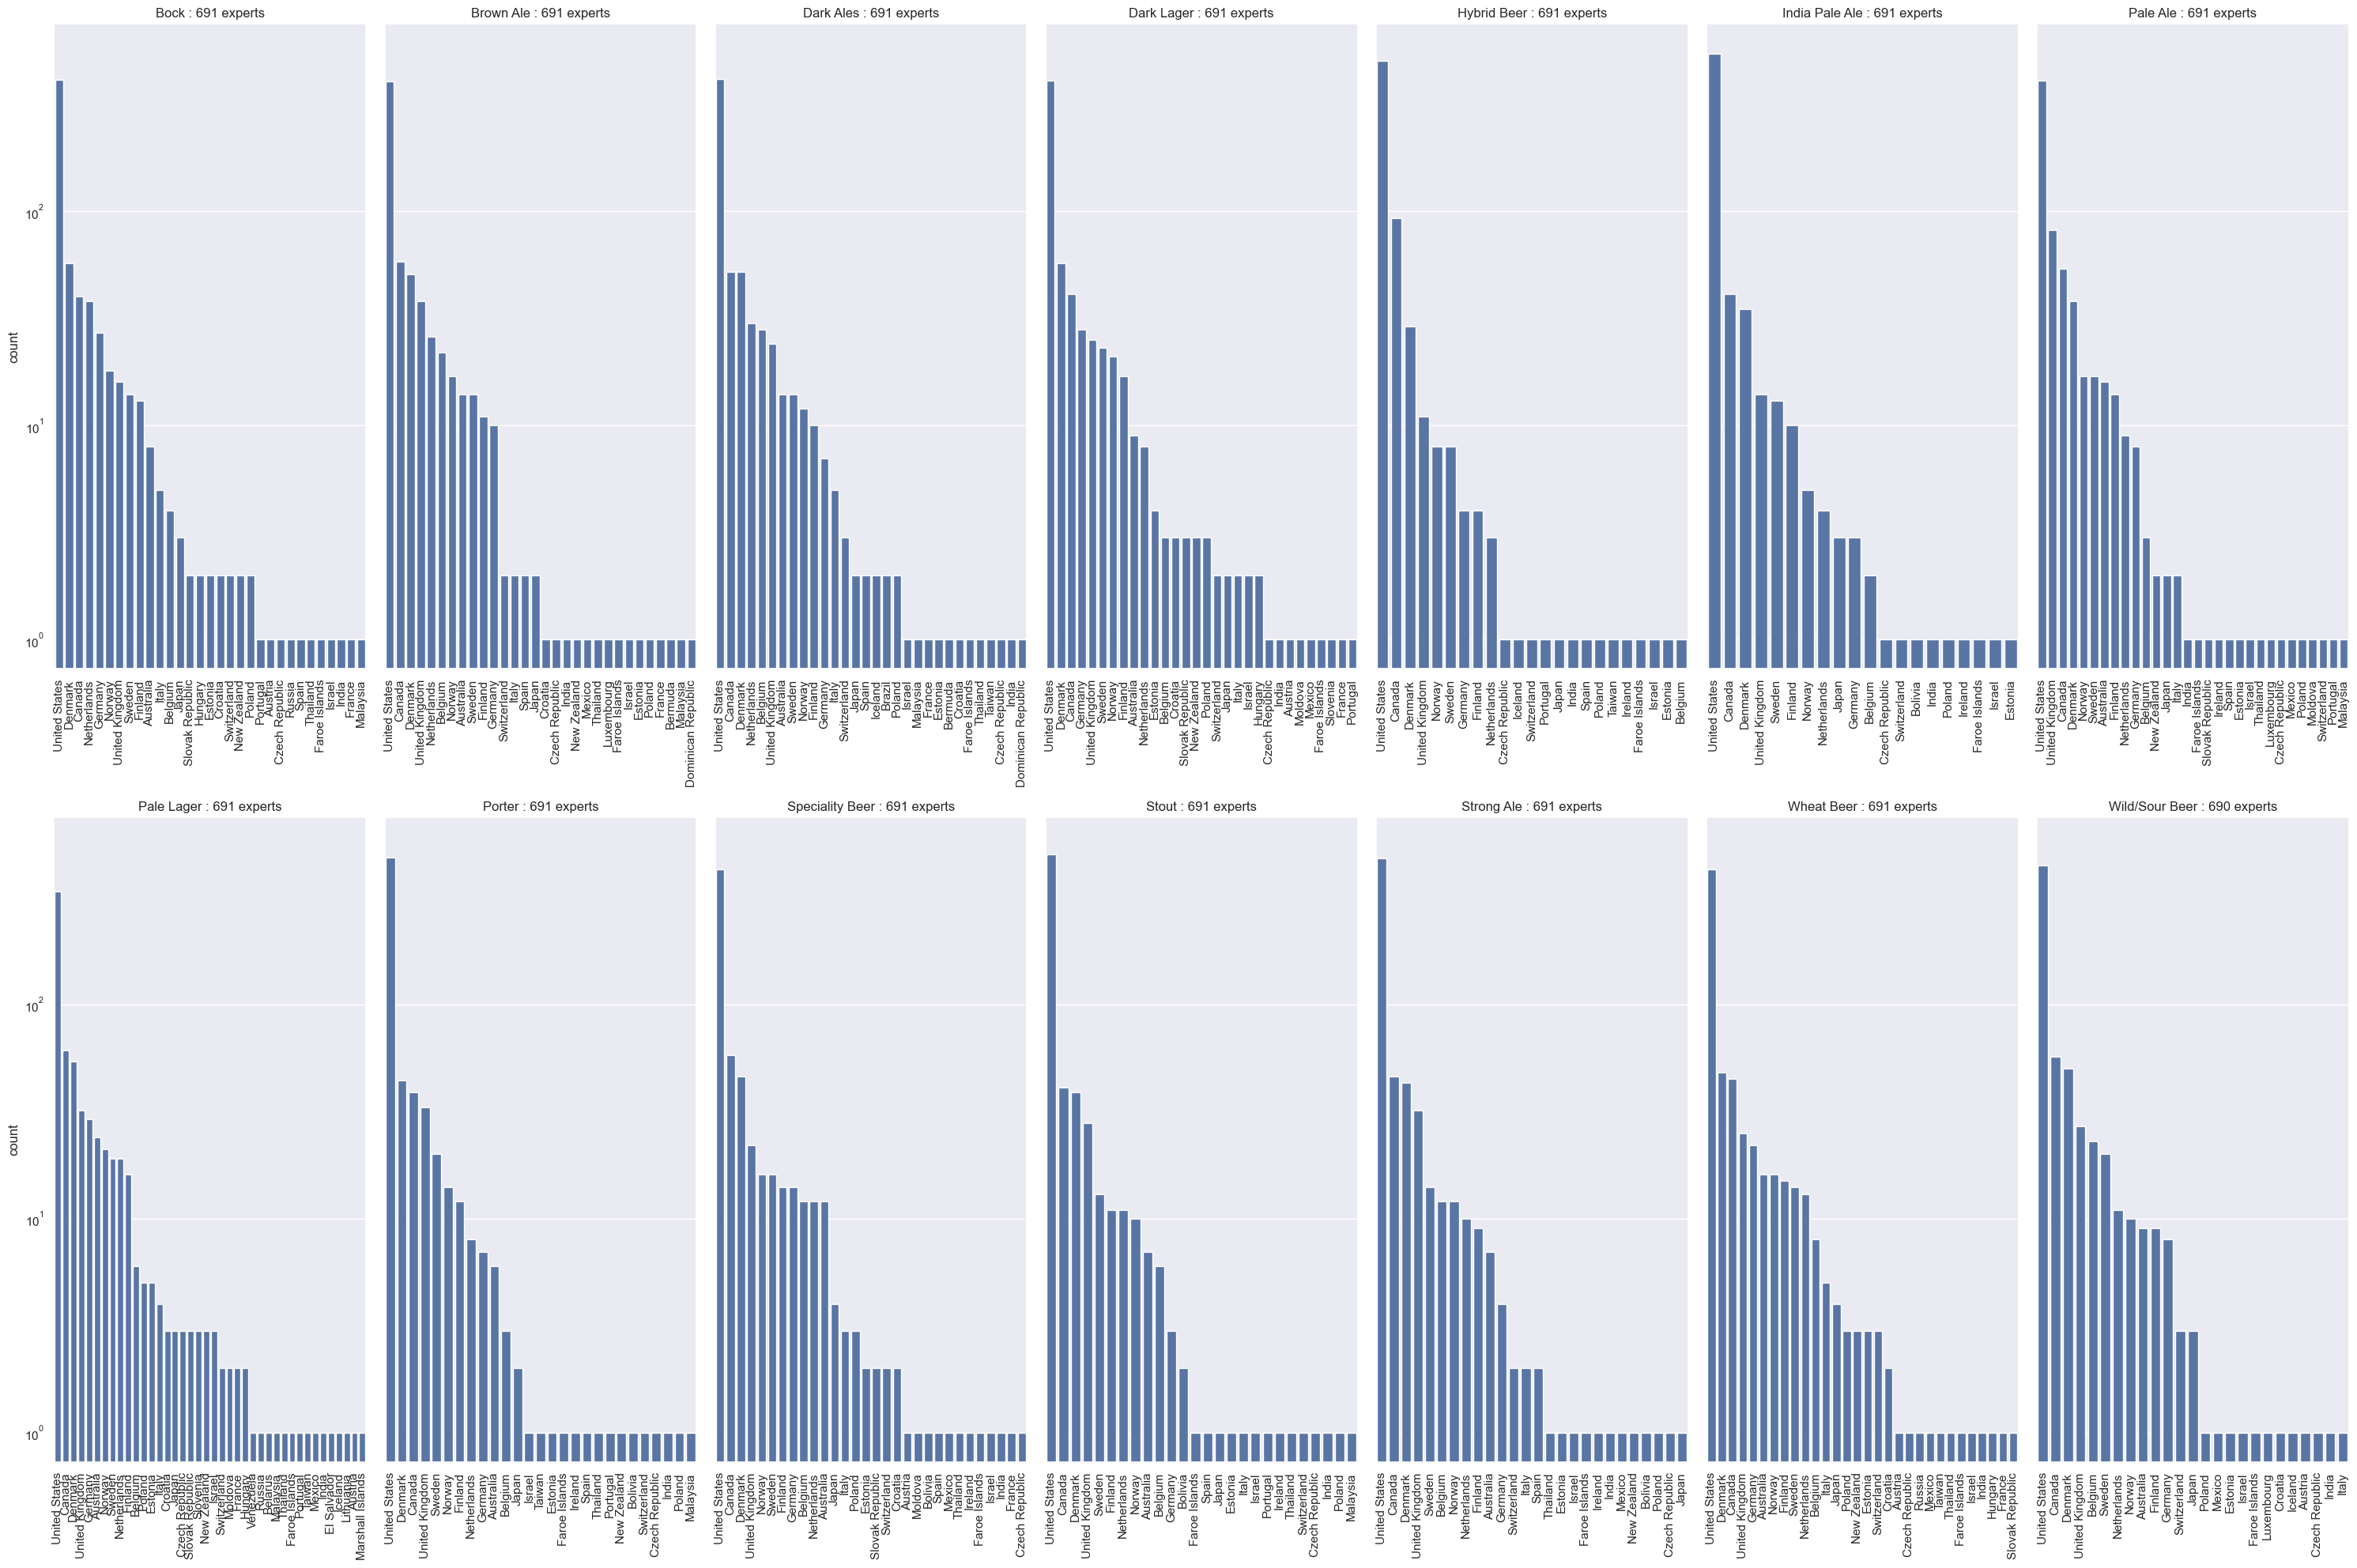

In [253]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)
for col_idx, col in enumerate(expert_columns):
    sns.barplot(df_expert_users[df_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

In [254]:
n_unique_experts_per_style.sort_values()

Wild/Sour Beer_expert     690
Bock_expert               691
Brown Ale_expert          691
Dark Ales_expert          691
Dark Lager_expert         691
Hybrid Beer_expert        691
India Pale Ale_expert     691
Pale Ale_expert           691
Pale Lager_expert         691
Porter_expert             691
Speciality Beer_expert    691
Stout_expert              691
Strong Ale_expert         691
Wheat Beer_expert         691
dtype: int64

In [255]:
df_rb_user_beer_style_past_ratings['date_month'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_rb_user_beer_style_past_ratings['date_quarter'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

In [256]:
df_expert_per_day = df_rb_user_beer_style_past_ratings[expert_columns+["date_quarter","user_id"]].groupby(["user_id","date_quarter"]).max().reset_index().iloc[:,1:].groupby("date_quarter").sum().reset_index()
df_expert_per_day_long = df_expert_per_day.melt(id_vars='date_quarter', var_name='Beer Style', value_name='Number of expert ratings')

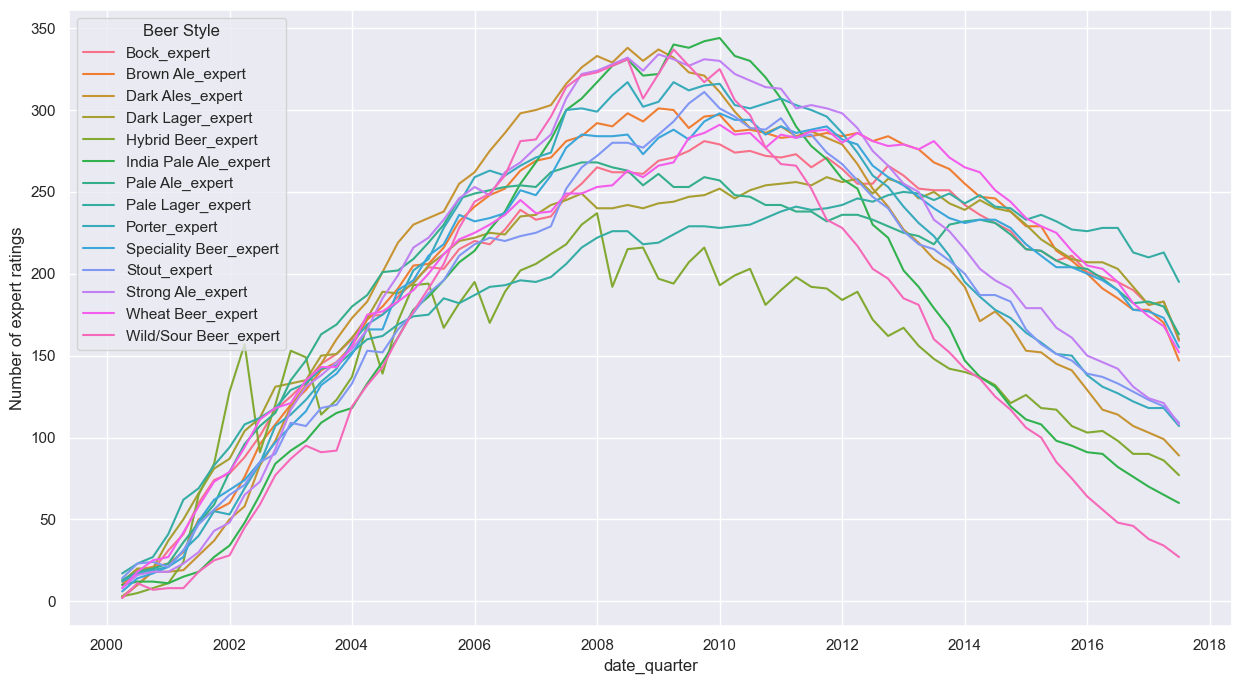

In [257]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long,x="date_quarter",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [258]:
df_expert_ratings = df_rb_user_beer_style_past_ratings[expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_rb_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in expert_columns:
    beer_rated_by_experts = df_expert_ratings[(df_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_expert_ratings[(df_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_expert_ratings["beer_id"].isin(top_k_beers))]
    df_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_to_barplot = pd.concat(df_to_plots,axis=0)

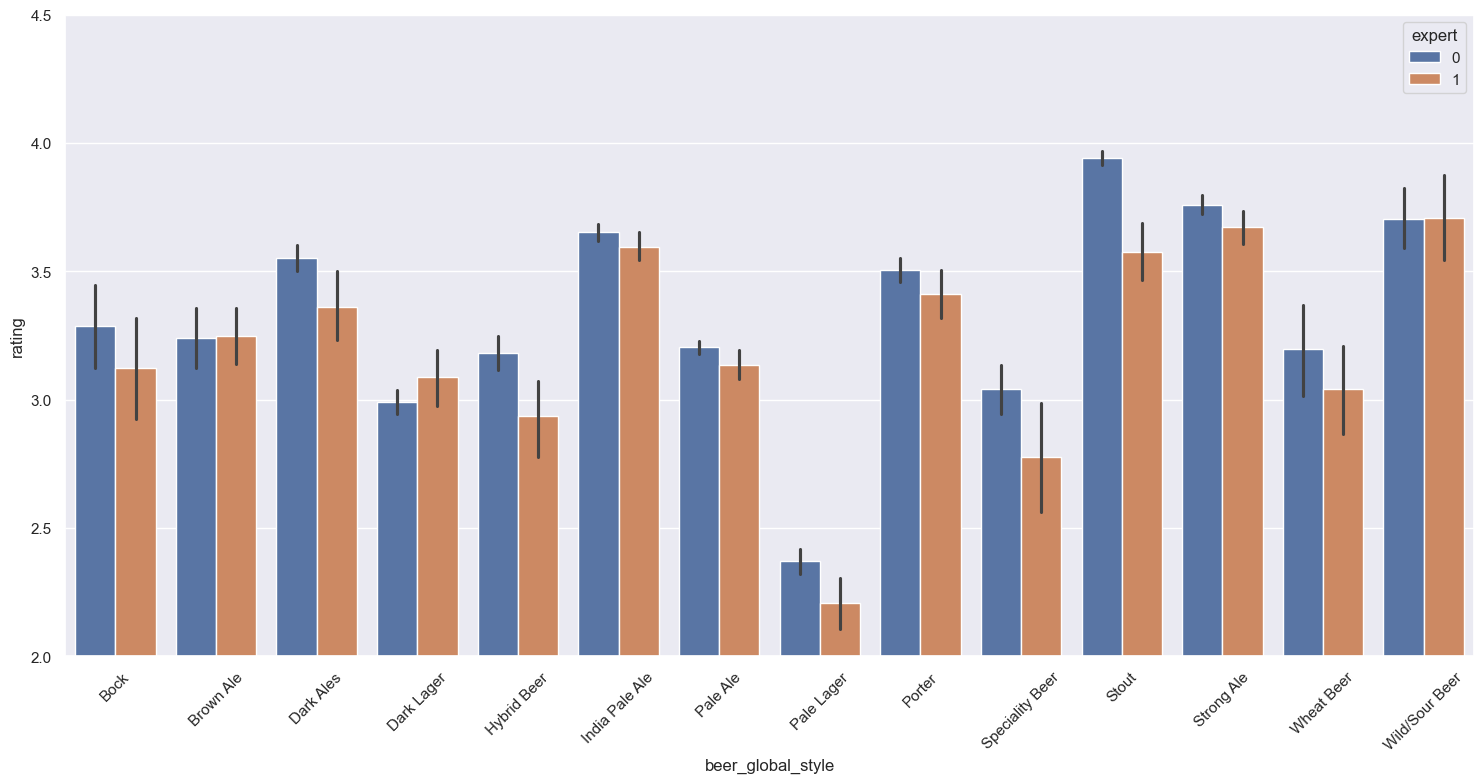

In [259]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_to_barplot,x="beer_global_style", y="rating", hue="expert")
#plt.errorbar(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], yerr=df_to_show["rating"]["sem"], fmt="none", c="black", capsize=5)
plt.xticks(rotation=45)
plt.ylim([2,4.5])
plt.tight_layout()
plt.show()

In [260]:
df_experts = df_rb_user_beer_style_past_ratings[expert_columns+["user_id","date_day"]]
df_rb_ratings = df_rb_ratings.dropna()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

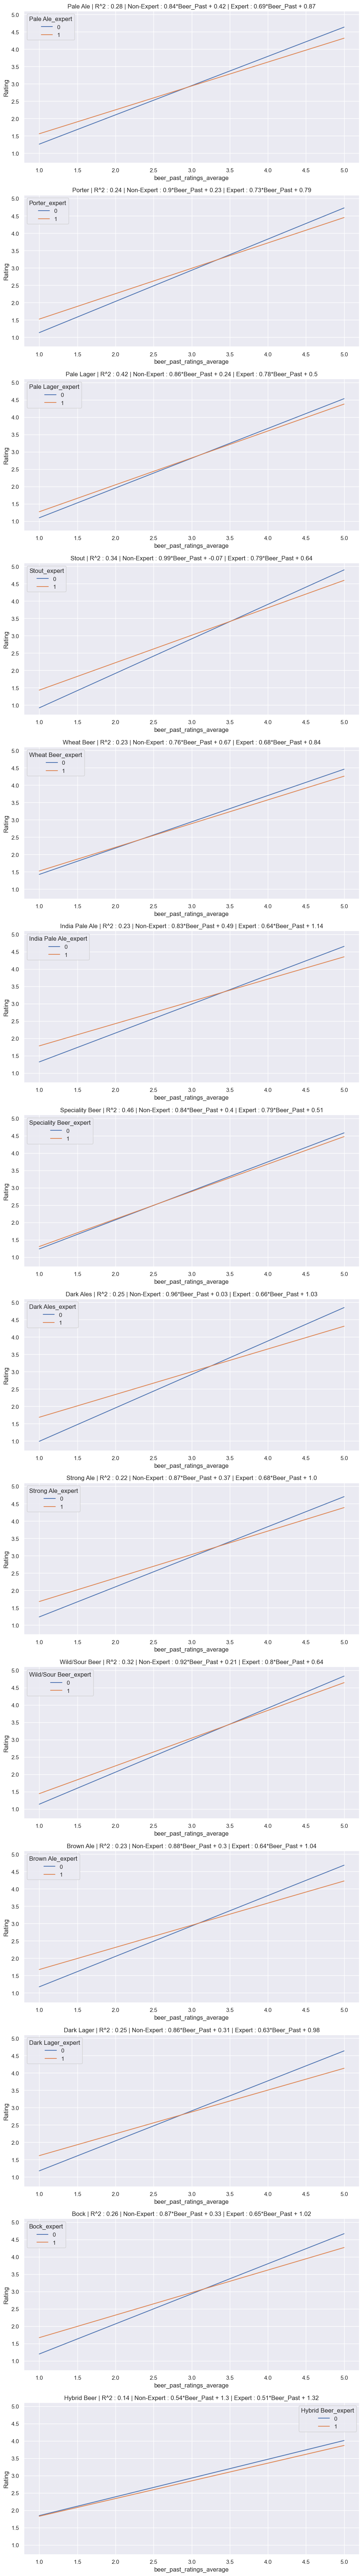

In [261]:
fig, axes = plt.subplots(14,1,figsize=(10,70),sharey=True)

for style_idx, beer_style in enumerate(df_rb_ratings["beer_global_style"].unique()):

    df_study = df_rb_ratings[df_rb_ratings["beer_global_style"] == beer_style][["user_id","date_day","beer_past_ratings_average","rating"]].merge(df_experts, how="left", on=["user_id","date_day"])
    X = df_study[[beer_style+"_expert", 'beer_past_ratings_average']]
    X.loc[:,"interaction"] = X[beer_style+"_expert"] * X["beer_past_ratings_average"]
    X.loc[:,"intercept"] = 1
    y = df_study['rating']
    reg = sm.OLS(y, X).fit()
    df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0],'intercept':[1,1,1,1]})
    #df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0]})

    prediction = reg.get_prediction(df_line)
    predicted_mean = prediction.predicted_mean
    conf_int = prediction.conf_int()

    df_line["predicted_rating"] = predicted_mean
    df_line["ci_lower"] = conf_int[:, 0]
    df_line["ci_upper"] = conf_int[:, 1]

    sns.lineplot(data = df_line, x = "beer_past_ratings_average", y = "predicted_rating", hue = beer_style+"_expert", legend=True, ax=axes[style_idx])
    axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past + {round(reg.params["intercept"],2)} | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params["intercept"] + reg.params[beer_style+"_expert"],2)}")
    #axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params[beer_style+"_expert"],2)}")
    axes[style_idx].set_ylabel("Rating")

    for expert in df_line[beer_style+"_expert"].unique():
        expert_data = df_line[df_line[beer_style+"_expert"] == expert]
        axes[style_idx].fill_between(
            expert_data["beer_past_ratings_average"], 
            expert_data["ci_lower"], 
            expert_data["ci_upper"], 
            alpha=0.2  # Adjust transparency of the shaded region
        )
plt.tight_layout()
plt.show()

# Graphical Approach of experts

## Shell Layout with nodes as expertise kind and beer styles

In [262]:
import networkx as nx
import community as community_louvain

MIN_EXPERT = 70
SIZE_STYLE = 1000
SIZE_EXPERT_MIN = 500

In [263]:
G = nx.Graph()

styles = df_rb_ratings["beer_global_style"].unique()
styles.sort()

styles_total = df_expert_users.iloc[:,1:-2].sum().to_dict()

user_expertise = dict()

for row in df_expert_users.iterrows():
    expertise = []
    for style_idx, style in enumerate(styles):
        if row[1][style_idx + 1] == 1:
            expertise.append(style)
    user_expertise[row[1][0]] = expertise

expertise_kinds = []
for val in user_expertise.values():
    if val not in expertise_kinds:
        expertise_kinds.append(val)

edge_sizes = []
for i, expertise in enumerate(expertise_kinds):
    size = list(user_expertise.values()).count(expertise)
    if size >= MIN_EXPERT and len(expertise) >= 2:
        G.add_node(str(i))
        for style in expertise:
            G.add_edge(style,str(i))
            expert_share = 100 * (size / styles_total[style+"_expert"])
            edge_sizes.append(expert_share)

colors = ["red","green","blue","orange","purple","cyan","magenta","yellow","pink","lime","teal","brown","gray","olive"]
kind_to_color_bis = {styles[i]:colors[i] for i in range(len(styles))}

edge_colors = []
for u,v in G.edges():
    if u in styles:
        edge_colors.append(kind_to_color_bis[u])
    else:
        edge_colors.append(kind_to_color_bis[v])

node_sizes = []
node_colors = []
experts = []
for node in G.nodes():
    if node in styles:
        node_sizes.append(SIZE_STYLE)
        node_colors.append(kind_to_color_bis[node])
    else:
        experts.append(node)
        expertises = expertise_kinds[int(node)]
        node_sizes.append(SIZE_EXPERT_MIN + list(user_expertise.values()).count(expertises))
        node_colors.append("black")

shells = [styles, experts]
pos = nx.shell_layout(G, shells)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/3789412746.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/3789412746.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



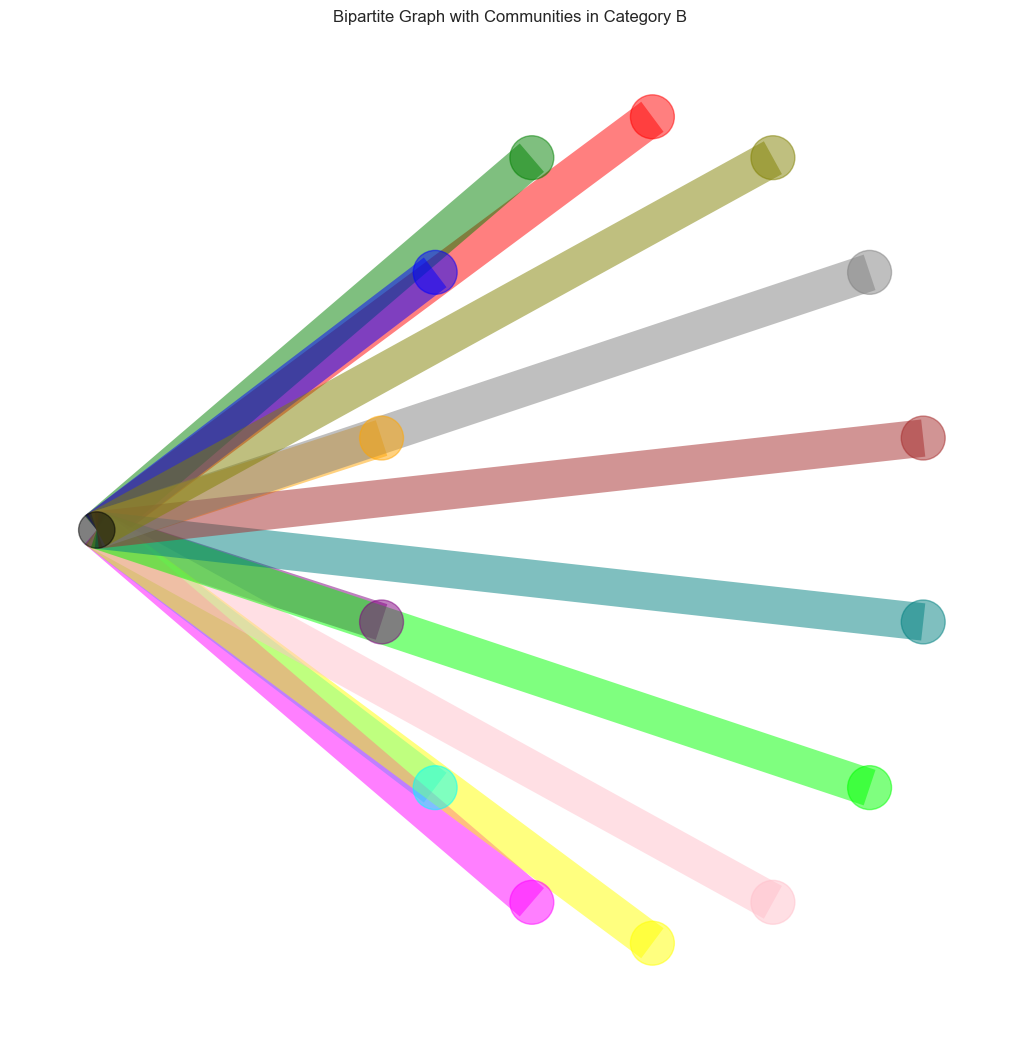

In [264]:
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_sizes,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

## Spring layout with nodes as users and beer styles

In [265]:
G_bis = nx.Graph()

styles = df_rb_ratings["beer_global_style"].unique()
styles.sort()

G_bis.add_nodes_from(styles)
G_bis.add_nodes_from(df_expert_users["user_id"])

df_expert_users_renamed = df_expert_users.rename(columns={style+"_expert":style for style in styles}).iloc[:,:-2]
df_edges = df_expert_users_renamed.melt(id_vars="user_id",var_name="style",value_name="edge")
G_bis.add_edges_from(df_edges[df_edges["edge"] == 1][["user_id","style"]].values)

nodes_to_remove = [node for node in G_bis.nodes() if G_bis.degree(node) == 1]

G_bis.remove_nodes_from(nodes_to_remove)

node_sizes = []
node_colors = []
for node in G_bis.nodes():
    if node in styles:
        node_sizes.append(500)
        node_colors.append("red")
    else:
        node_colors.append("blue")
        node_sizes.append(10)

user_nodes = [node for node in G_bis.nodes() if node in df_expert_users_renamed["user_id"]]
style_nodes = [node for node in G_bis.nodes() if node in styles]

all_pos = nx.spring_layout(G_bis, seed=42)

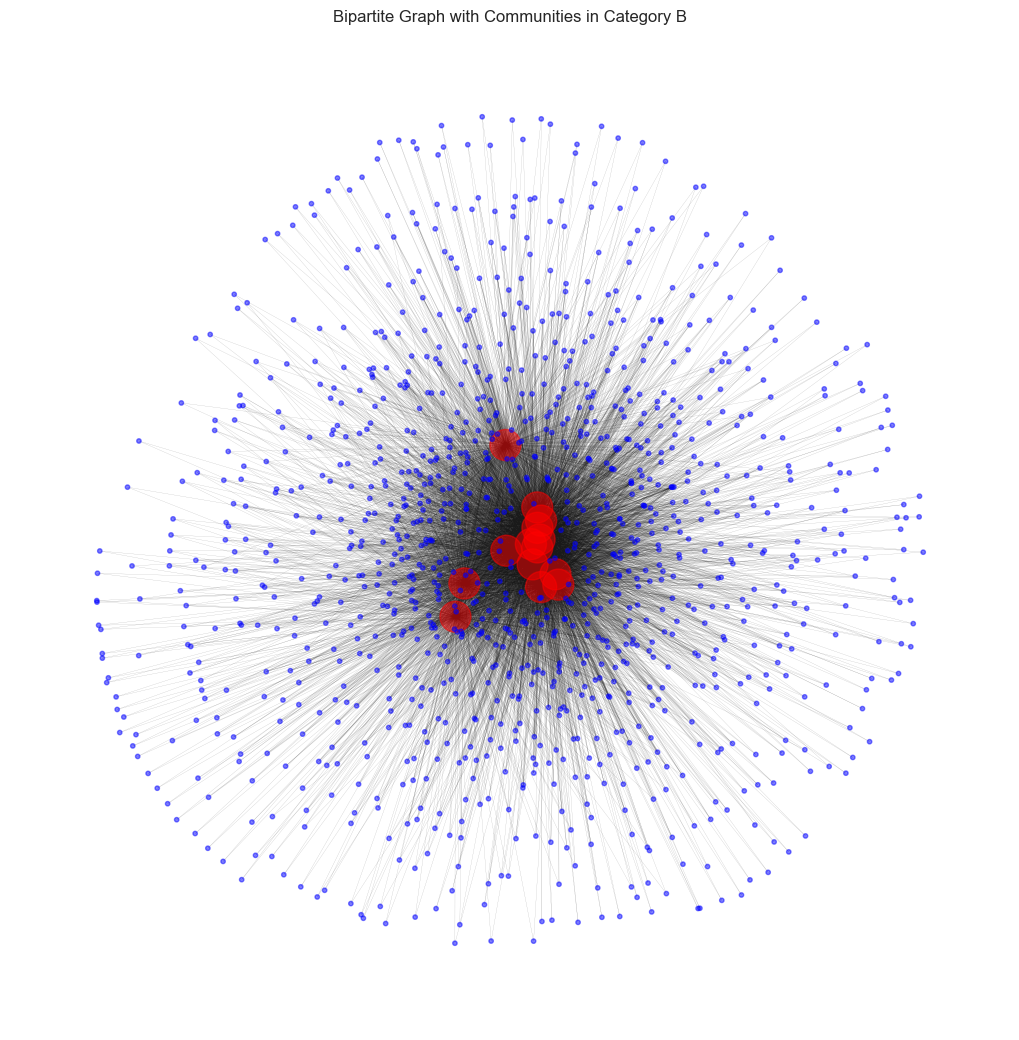

In [266]:
plt.figure(figsize=(10, 10))
nx.draw(
    G_bis,
    all_pos,
    node_size=node_sizes,
    node_color=node_colors,
    width=0.1,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()